In [382]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp
pd.options.mode.chained_assignment = None


In [394]:

def backtest_strategy(data, rsi_period, rsi_ob, rsi_os, bollinger_ma, bollinger_n_std_dev, tsl):
    df = data.copy()
    df['Regular Return'] = df['Close'].pct_change()
    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=rsi_period).rsi()

    # Bollinger Bands
    mavg = df['Close'].rolling(window=bollinger_ma).mean()
    rolling_std = df['Close'].rolling(window=bollinger_ma).std()
    df['Bollinger High'] = mavg + rolling_std * bollinger_n_std_dev
    df['Bollinger Low'] = mavg - rolling_std * bollinger_n_std_dev

    # Buy/Sell signals
    df['Signal'] = 0  # Neutral
    df['Position'] = 0

    # Stop losses
    trailing_stop = 0

    for i in range(len(df)):
        # Same position as previous day
        df['Position'].iloc[i] = df['Position'].iloc[i-1] if i > 0 else 0

        trailing_stop = max((1-tsl) * df['Close'].iloc[i], trailing_stop) if df['Position'].iloc[i] > 0 else 0

        # The signal is current close < bollinger low and rsi < 30.
        # If both are satisfied and I am not holding, I long the stock
        if df['Position'].iloc[i] == 0 and (df['Close'].iloc[i] < df['Bollinger Low'].iloc[i] and df['RSI'].iloc[i] < rsi_os):
            df['Signal'].iloc[i] = 1  # Buy
            df['Position'].iloc[i] = 1
            trailing_stop = (1-tsl) * df['Close'].iloc[i]

        elif df['Position'].iloc[i] > 0 and df['Close'].iloc[i] <= trailing_stop:
            df['Signal'].iloc[i] = -1
            df['Position'].iloc[i] = 0
            trailing_stop = 0
        
        # Exit signal
        elif df['Position'].iloc[i] > 0 and (df['Close'].iloc[i] > df['Bollinger High'].iloc[i] and df['RSI'].iloc[i] > rsi_ob):
            df['Signal'].iloc[i] = -1
            df['Position'].iloc[i] = 0
            trailing_stop = 0

    # Log Returns, Cumulative Returns, etc.
    df['Log Return'] = np.log(df['Close']/df['Close'].shift(1))
    df['Benchmark Log Return'] = np.log(df['Benchmark']/df['Benchmark'].shift(1))
    df['Benchmark Regular Return'] = df['Benchmark'].pct_change()
    df['Strategy Log Return'] = df['Position'] * df['Log Return']
    df['Strategy Regular Return'] = df['Position'] * df['Regular Return']

    df['Cumulative Asset Returns'] = df['Regular Return'].cumsum()
    df['Cumulative Market Returns'] = np.exp(df['Benchmark Log Return'].cumsum()) -1
    df['Cumulative Strategy Returns'] = np.exp(df['Strategy Log Return'].cumsum()) -1

    # Annualized Standard Deviation of Log returns
    annualized_log_std = df['Strategy Log Return'].std() * np.sqrt(252)
    annualized_log_return = df['Strategy Log Return'].mean() * 252

     # Annualized Return
    annualized_regular_return = df['Strategy Regular Return'].mean() * 252
    annualized_regular_std = df['Strategy Regular Return'].std() * np.sqrt(252)

    # Calculate Beta
    cov_matrix = np.cov(df['Strategy Regular Return'][1:], df['Benchmark Regular Return'][1:])
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]

    # Calculate Alpha (assuming risk-free rate = 0)
    market_return = df['Benchmark Regular Return'].mean() * 252
    strategy_return = df['Strategy Regular Return'].mean() * 252
    alpha = strategy_return - (beta * market_return)

    # Sharpe Ratio (assuming risk-free rate = 0)
    sharpe_ratio = annualized_regular_return / annualized_regular_std

    # Sortino Ratio
    df['Negative Return'] = df[df['Strategy Log Return']<0]['Strategy Log Return']
    negative_regular_return = np.exp(df['Negative Return']) -1
    annualized_negative_sd = negative_regular_return.std() * np.sqrt(252)
    sortino_ratio = annualized_regular_return / annualized_negative_sd

    # Maximum Drawdown
    df['Running Max'] = df['Cumulative Strategy Returns'].cummax()
    df['Drawdown'] = df['Running Max'] - df['Cumulative Strategy Returns']
    max_drawdown = df['Drawdown'].max()
    zero_periods = df['Drawdown'][df['Drawdown'] == 0]
    delta_values = zero_periods.index[1:] - zero_periods.index[:-1]
    max_drawdown_duration = delta_values.max()

    # Treymor
    treymor_ratio = annualized_regular_return / beta

    # Calmar ratio
    calmar_ratio = annualized_regular_return / max_drawdown

    # Information ratio
    average_of_difference = (df['Strategy Regular Return'] - df['Benchmark Regular Return']).mean()
    std_of_difference = (df['Strategy Regular Return'] - df['Benchmark Regular Return']).std()
    information_ratio_daily = average_of_difference / std_of_difference
    information_ratio = information_ratio_daily * np.sqrt(252)

    metrics = {
        'Annualized Regular Returns': annualized_regular_return,
        'Annualized Regular Std Dev': annualized_regular_std,
        'Annualized Log Std Dev': annualized_log_std,
        'Annualized Log Returns': annualized_log_return,
        'Beta': beta,
        'Alpha': alpha,
        'Tremor Ratio': treymor_ratio,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown,
        'Calmar Ratio': calmar_ratio,
        'Max Drawdown Duration': max_drawdown_duration,
        'Information Ratio': information_ratio,
        'Final Cumulative Return': df['Cumulative Strategy Returns'].iloc[-1]
    }

    return df, metrics


In [395]:
# Hyper optimization
search_space = {
    'BBMA': [5, 10, 20, 50],
    'BBSD': [1, 1.5, 2],
    'RSILBP': [14, 25, 50],
    'RSIOB': [70, 80],
    'RSIOS': [30, 20],
    'TSL': [0.03, 0.04, 0.05]
}

def get_hyperparam(param, idx):
    return search_space[param][idx]

def hyperopt(ticker):
    data = yf.download(ticker, start="2015-01-01", end="2020-01-01")
    benchmark = yf.download('SPY', start="2015-01-01", end="2020-01-01")
    benchmark = benchmark.rename(columns={'Close':'Benchmark'})
    data = pd.concat([data, benchmark['Benchmark']], axis=1)

    def objective(params):
        bollinger_ma, bollinger_n_std_dev, rsi_period, rsi_ob, rsi_os, tsl = params
        df, metrics = backtest_strategy(data, rsi_period, rsi_ob, rsi_os, bollinger_ma, bollinger_n_std_dev, tsl)
        return -1 * metrics['Sharpe Ratio'] # * -1 to make it a maximization problem

    space=(
        hp.choice('BBMA', search_space['BBMA']),
        hp.choice('BBSD', search_space['BBSD']),
        hp.choice('RSILBP', search_space['RSILBP']),
        hp.choice('RSIOB', search_space['RSIOB']),
        hp.choice('RSIOS', search_space['RSIOS']),
        hp.choice('TSL', search_space['TSL']),
    )
    MAX_EVALS = 432
    optimization_algorithm = tpe.suggest
    best = fmin(fn=objective, space=space, algo=optimization_algorithm, max_evals=MAX_EVALS)
    print('Best Hyperparameter: ', best)

    return best

In [396]:
results = {}
symbols = ['META', 'AMZN', 'AAPL','NFLX', 'GOOGL']
# symbols = ['META']
for symbol in symbols:
    params = hyperopt(symbol)
    bbma, bbsd, rsilbp, rsiob, rsios, tsl = get_hyperparam('BBMA', params['BBMA']), get_hyperparam('BBSD', params['BBSD']), get_hyperparam('RSILBP', params['RSILBP']), get_hyperparam('RSIOB', params['RSIOB']), get_hyperparam('RSIOS', params['RSIOS']), get_hyperparam('TSL', params['TSL'])

    # Use the optimal parameter
    data = yf.download(symbol, start="2015-01-01", end="2020-01-01")
    benchmark = yf.download('SPY', start="2015-01-01", end="2020-01-01")
    benchmark = benchmark.rename(columns={'Close':'Benchmark'})
    data = pd.concat([data, benchmark['Benchmark']], axis=1)
    df, metrics = backtest_strategy(data, rsi_period=rsilbp, rsi_ob=rsiob, rsi_os=rsios, bollinger_ma=bbma, bollinger_n_std_dev=bbsd, tsl=tsl)
    results[symbol] = (df, metrics, params)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
  0%|          | 2/432 [00:00<00:49,  8.67trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



  1%|          | 4/432 [00:00<00:46,  9.26trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  1%|▏         | 6/432 [00:00<00:45,  9.45trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  2%|▏         | 8/432 [00:00<00:45,  9.23trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  2%|▏         | 10/432 [00:01<00:44,  9.47trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  3%|▎         | 12/432 [00:01<00:44,  9.33trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  3%|▎         | 14/432 [00:01<00:45,  9.24trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  4%|▎         | 16/432 [00:01<00:44,  9.33trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  4%|▍         | 18/432 [00:01<00:43,  9.47trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  5%|▍         | 20/432 [00:02<00:43,  9.58trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  5%|▌         | 22/432 [00:02<00:42,  9.56trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  6%|▌         | 24/432 [00:02<00:50,  8.07trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  6%|▌         | 26/432 [00:02<00:47,  8.58trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  6%|▋         | 28/432 [00:03<00:43,  9.20trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  7%|▋         | 30/432 [00:03<00:42,  9.48trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  8%|▊         | 33/432 [00:03<00:41,  9.53trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



  8%|▊         | 35/432 [00:03<00:41,  9.66trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  9%|▊         | 37/432 [00:03<00:41,  9.59trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  9%|▉         | 40/432 [00:04<00:41,  9.38trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 10%|▉         | 42/432 [00:04<00:41,  9.45trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 10%|█         | 44/432 [00:04<00:40,  9.57trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 11%|█         | 46/432 [00:04<00:39,  9.67trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 11%|█         | 48/432 [00:05<00:39,  9.74trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 12%|█▏        | 50/432 [00:05<00:39,  9.77trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 12%|█▏        | 52/432 [00:05<00:39,  9.55trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 12%|█▎        | 54/432 [00:05<00:39,  9.61trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 13%|█▎        | 56/432 [00:05<00:40,  9.28trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 13%|█▎        | 58/432 [00:06<00:39,  9.51trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 14%|█▍        | 60/432 [00:06<00:39,  9.34trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 14%|█▍        | 62/432 [00:06<00:40,  9.15trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 15%|█▍        | 64/432 [00:06<00:40,  9.17trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 15%|█▌        | 66/432 [00:07<00:39,  9.32trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 16%|█▌        | 68/432 [00:07<00:39,  9.22trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 16%|█▌        | 70/432 [00:07<00:39,  9.25trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 17%|█▋        | 72/432 [00:07<00:38,  9.32trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 17%|█▋        | 74/432 [00:07<00:37,  9.57trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 18%|█▊        | 77/432 [00:08<00:38,  9.21trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 18%|█▊        | 79/432 [00:08<00:38,  9.05trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 19%|█▉        | 81/432 [00:08<00:37,  9.32trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 19%|█▉        | 83/432 [00:08<00:38,  8.96trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 20%|█▉        | 85/432 [00:09<00:37,  9.28trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 20%|██        | 87/432 [00:09<00:36,  9.53trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 21%|██        | 89/432 [00:09<00:35,  9.70trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 21%|██        | 91/432 [00:09<00:34,  9.79trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 22%|██▏       | 93/432 [00:09<00:34,  9.81trial/s, best loss: -0.6847290964785013]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 22%|██▏       | 96/432 [00:10<00:37,  8.92trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 23%|██▎       | 98/432 [00:10<00:37,  8.92trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 23%|██▎       | 100/432 [00:10<00:35,  9.29trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 24%|██▎       | 102/432 [00:10<00:34,  9.57trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 24%|██▍       | 104/432 [00:11<00:33,  9.72trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 25%|██▍       | 106/432 [00:11<00:33,  9.75trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 25%|██▌       | 108/432 [00:11<00:33,  9.77trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 26%|██▌       | 111/432 [00:11<00:33,  9.57trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 26%|██▌       | 113/432 [00:12<00:33,  9.59trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 27%|██▋       | 115/432 [00:12<00:32,  9.67trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 27%|██▋       | 117/432 [00:12<00:32,  9.70trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 28%|██▊       | 120/432 [00:12<00:32,  9.60trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 28%|██▊       | 122/432 [00:12<00:32,  9.56trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 29%|██▊       | 124/432 [00:13<00:32,  9.58trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 29%|██▉       | 126/432 [00:13<00:33,  9.27trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 30%|██▉       | 128/432 [00:13<00:32,  9.32trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 30%|███       | 130/432 [00:13<00:31,  9.47trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 31%|███       | 132/432 [00:14<00:31,  9.46trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 31%|███       | 134/432 [00:14<00:30,  9.62trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 31%|███▏      | 136/432 [00:14<00:30,  9.59trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 32%|███▏      | 139/432 [00:14<00:30,  9.46trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 33%|███▎      | 141/432 [00:14<00:30,  9.58trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 33%|███▎      | 143/432 [00:15<00:29,  9.68trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 34%|███▍      | 146/432 [00:15<00:29,  9.71trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 34%|███▍      | 148/432 [00:15<00:29,  9.60trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 35%|███▍      | 150/432 [00:15<00:29,  9.71trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 35%|███▌      | 152/432 [00:16<00:28,  9.80trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown


 36%|███▌      | 155/432 [00:16<00:28,  9.74trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 36%|███▋      | 157/432 [00:16<00:28,  9.68trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 37%|███▋      | 159/432 [00:16<00:28,  9.75trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 37%|███▋      | 161/432 [00:17<00:27,  9.76trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 38%|███▊      | 163/432 [00:17<00:28,  9.49trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 38%|███▊      | 166/432 [00:17<00:28,  9.44trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 39%|███▉      | 168/432 [00:17<00:27,  9.59trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 40%|███▉      | 171/432 [00:18<00:27,  9.59trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 40%|████      | 173/432 [00:18<00:27,  9.56trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 41%|████      | 175/432 [00:18<00:27,  9.51trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 41%|████      | 177/432 [00:18<00:27,  9.26trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 41%|████▏     | 179/432 [00:18<00:27,  9.32trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 42%|████▏     | 181/432 [00:19<00:26,  9.50trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 42%|████▏     | 183/432 [00:19<00:25,  9.63trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 43%|████▎     | 185/432 [00:19<00:25,  9.54trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 43%|████▎     | 187/432 [00:19<00:25,  9.52trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 44%|████▍     | 189/432 [00:20<00:25,  9.50trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 44%|████▍     | 191/432 [00:20<00:25,  9.40trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 45%|████▍     | 193/432 [00:20<00:25,  9.40trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 45%|████▌     | 195/432 [00:20<00:25,  9.47trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 46%|████▌     | 197/432 [00:20<00:24,  9.54trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 46%|████▌     | 199/432 [00:21<00:24,  9.56trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 47%|████▋     | 201/432 [00:21<00:24,  9.55trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 47%|████▋     | 203/432 [00:21<00:23,  9.62trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 47%|████▋     | 205/432 [00:21<00:23,  9.64trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 48%|████▊     | 207/432 [00:21<00:23,  9.64trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 48%|████▊     | 209/432 [00:22<00:23,  9.64trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 49%|████▉     | 211/432 [00:22<00:22,  9.66trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 49%|████▉     | 213/432 [00:22<00:22,  9.66trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 50%|████▉     | 215/432 [00:22<00:22,  9.70trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 50%|█████     | 217/432 [00:22<00:22,  9.66trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 51%|█████     | 219/432 [00:23<00:22,  9.66trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 51%|█████     | 221/432 [00:23<00:21,  9.61trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 52%|█████▏    | 223/432 [00:23<00:21,  9.51trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 52%|█████▏    | 225/432 [00:23<00:21,  9.58trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 53%|█████▎    | 227/432 [00:23<00:21,  9.60trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 53%|█████▎    | 229/432 [00:24<00:21,  9.62trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 53%|█████▎    | 231/432 [00:24<00:20,  9.63trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 54%|█████▍    | 233/432 [00:24<00:21,  9.27trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 54%|█████▍    | 235/432 [00:24<00:20,  9.41trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 55%|█████▍    | 237/432 [00:25<00:20,  9.53trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 55%|█████▌    | 239/432 [00:25<00:20,  9.31trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 56%|█████▌    | 241/432 [00:25<00:20,  9.44trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 56%|█████▋    | 243/432 [00:25<00:19,  9.56trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 57%|█████▋    | 245/432 [00:25<00:19,  9.60trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 57%|█████▋    | 247/432 [00:26<00:20,  9.10trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 58%|█████▊    | 249/432 [00:26<00:20,  8.86trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 58%|█████▊    | 251/432 [00:26<00:21,  8.40trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 59%|█████▊    | 253/432 [00:26<00:19,  8.97trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 59%|█████▉    | 255/432 [00:27<00:19,  9.28trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 59%|█████▉    | 257/432 [00:27<00:18,  9.51trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 60%|█████▉    | 259/432 [00:27<00:18,  9.30trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 60%|██████    | 261/432 [00:27<00:17,  9.53trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 61%|██████    | 263/432 [00:27<00:17,  9.58trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 61%|██████▏   | 265/432 [00:28<00:17,  9.60trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 62%|██████▏   | 267/432 [00:28<00:17,  9.63trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 62%|██████▏   | 269/432 [00:28<00:16,  9.66trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 63%|██████▎   | 271/432 [00:28<00:16,  9.71trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 63%|██████▎   | 273/432 [00:28<00:16,  9.71trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 64%|██████▎   | 275/432 [00:29<00:16,  9.66trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 64%|██████▍   | 277/432 [00:29<00:15,  9.71trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 65%|██████▍   | 279/432 [00:29<00:16,  9.52trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 65%|██████▌   | 281/432 [00:29<00:15,  9.49trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 66%|██████▌   | 283/432 [00:29<00:15,  9.55trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 66%|██████▌   | 285/432 [00:30<00:15,  9.54trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 66%|██████▋   | 287/432 [00:30<00:15,  9.57trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 67%|██████▋   | 289/432 [00:30<00:14,  9.59trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 67%|██████▋   | 291/432 [00:30<00:14,  9.54trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 68%|██████▊   | 293/432 [00:30<00:14,  9.58trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 68%|██████▊   | 295/432 [00:31<00:14,  9.59trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 69%|██████▉   | 297/432 [00:31<00:14,  9.62trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 69%|██████▉   | 299/432 [00:31<00:13,  9.61trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 70%|██████▉   | 301/432 [00:31<00:13,  9.64trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 70%|███████   | 303/432 [00:32<00:13,  9.61trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 71%|███████   | 305/432 [00:32<00:13,  9.60trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 71%|███████   | 307/432 [00:32<00:12,  9.62trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 72%|███████▏  | 309/432 [00:32<00:12,  9.57trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 72%|███████▏  | 311/432 [00:32<00:12,  9.62trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 72%|███████▏  | 313/432 [00:33<00:12,  9.67trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 73%|███████▎  | 315/432 [00:33<00:12,  9.59trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 73%|███████▎  | 317/432 [00:33<00:11,  9.61trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 74%|███████▍  | 319/432 [00:33<00:11,  9.62trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 74%|███████▍  | 321/432 [00:33<00:11,  9.59trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 75%|███████▍  | 323/432 [00:34<00:11,  9.63trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 75%|███████▌  | 325/432 [00:34<00:11,  9.63trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 76%|███████▌  | 327/432 [00:34<00:10,  9.63trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 76%|███████▌  | 329/432 [00:34<00:10,  9.63trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 77%|███████▋  | 331/432 [00:34<00:10,  9.61trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 77%|███████▋  | 333/432 [00:35<00:10,  9.62trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 78%|███████▊  | 335/432 [00:35<00:10,  9.60trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 78%|███████▊  | 337/432 [00:35<00:09,  9.51trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 78%|███████▊  | 339/432 [00:35<00:09,  9.50trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 79%|███████▉  | 341/432 [00:35<00:09,  9.51trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 79%|███████▉  | 343/432 [00:36<00:09,  9.59trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 80%|███████▉  | 345/432 [00:36<00:09,  9.61trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 80%|████████  | 347/432 [00:36<00:08,  9.63trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 81%|████████  | 349/432 [00:36<00:08,  9.61trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 81%|████████▏ | 351/432 [00:37<00:08,  9.61trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 82%|████████▏ | 353/432 [00:37<00:08,  9.63trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 82%|████████▏ | 355/432 [00:37<00:08,  9.27trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 83%|████████▎ | 357/432 [00:37<00:07,  9.40trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 83%|████████▎ | 359/432 [00:37<00:07,  9.54trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 84%|████████▎ | 361/432 [00:38<00:07,  9.61trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 84%|████████▍ | 363/432 [00:38<00:07,  9.62trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 84%|████████▍ | 365/432 [00:38<00:06,  9.69trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 85%|████████▍ | 367/432 [00:38<00:06,  9.35trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 85%|████████▌ | 369/432 [00:38<00:06,  9.17trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 86%|████████▌ | 371/432 [00:39<00:06,  9.37trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 86%|████████▋ | 373/432 [00:39<00:06,  9.51trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 87%|████████▋ | 375/432 [00:39<00:06,  9.31trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 87%|████████▋ | 377/432 [00:39<00:05,  9.45trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 88%|████████▊ | 379/432 [00:39<00:05,  9.54trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 88%|████████▊ | 381/432 [00:40<00:05,  9.60trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 89%|████████▊ | 383/432 [00:40<00:05,  9.64trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 89%|████████▉ | 385/432 [00:40<00:04,  9.65trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 90%|████████▉ | 387/432 [00:40<00:04,  9.63trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 90%|█████████ | 389/432 [00:41<00:04,  9.64trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 91%|█████████ | 391/432 [00:41<00:04,  9.62trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 91%|█████████ | 393/432 [00:41<00:04,  9.63trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 91%|█████████▏| 395/432 [00:41<00:03,  9.60trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 92%|█████████▏| 397/432 [00:41<00:03,  9.59trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 92%|█████████▏| 399/432 [00:42<00:03,  9.62trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 93%|█████████▎| 401/432 [00:42<00:03,  9.64trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 93%|█████████▎| 403/432 [00:42<00:03,  9.62trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 94%|█████████▍| 405/432 [00:42<00:02,  9.61trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 94%|█████████▍| 407/432 [00:42<00:02,  9.61trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 95%|█████████▍| 409/432 [00:43<00:02,  9.61trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 95%|█████████▌| 411/432 [00:43<00:02,  9.59trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 96%|█████████▌| 413/432 [00:43<00:01,  9.60trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 96%|█████████▌| 415/432 [00:43<00:01,  9.51trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 97%|█████████▋| 417/432 [00:43<00:01,  9.58trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 97%|█████████▋| 419/432 [00:44<00:01,  9.59trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 97%|█████████▋| 421/432 [00:44<00:01,  9.60trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 98%|█████████▊| 423/432 [00:44<00:00,  9.64trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 98%|█████████▊| 425/432 [00:44<00:00,  9.65trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 99%|█████████▉| 427/432 [00:44<00:00,  9.64trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 99%|█████████▉| 429/432 [00:45<00:00,  9.64trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

100%|█████████▉| 431/432 [00:45<00:00,  9.63trial/s, best loss: -0.6962943348831154]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

100%|██████████| 432/432 [00:45<00:00,  9.50trial/s, best loss: -0.6962943348831154]
Best Hyperparameter:  {'BBMA': 2, 'BBSD': 1, 'RSILBP': 0, 'RSIOB': 1, 'RSIOS': 0, 'TSL': 0}
[*********************100%%**********************]  1 of 1 completed

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown




[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
  0%|          | 2/432 [00:00<00:46,  9.33trial/s, best loss=?]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  1%|          | 3/432 [00:00<00:45,  9.53trial/s, best loss=?]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  2%|▏         | 7/432 [00:00<00:43,  9.71trial/s, best loss: -0.6739781011537799]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



  2%|▏         | 9/432 [00:00<00:43,  9.76trial/s, best loss: -0.6739781011537799]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  3%|▎         | 11/432 [00:01<00:42,  9.81trial/s, best loss: -0.6739781011537799]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  3%|▎         | 15/432 [00:01<00:43,  9.62trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



  4%|▍         | 17/432 [00:01<00:42,  9.71trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



  4%|▍         | 19/432 [00:01<00:42,  9.75trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  5%|▍         | 21/432 [00:02<00:42,  9.75trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  5%|▌         | 23/432 [00:02<00:41,  9.74trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  6%|▌         | 25/432 [00:02<00:41,  9.75trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  6%|▋         | 28/432 [00:02<00:41,  9.76trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  7%|▋         | 30/432 [00:03<00:41,  9.79trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



  7%|▋         | 32/432 [00:03<00:40,  9.80trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  8%|▊         | 34/432 [00:03<00:40,  9.86trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  9%|▊         | 37/432 [00:03<00:39,  9.88trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  9%|▉         | 40/432 [00:04<00:40,  9.76trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 10%|▉         | 42/432 [00:04<00:39,  9.80trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 10%|█         | 44/432 [00:04<00:39,  9.80trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 11%|█         | 47/432 [00:04<00:39,  9.80trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 11%|█▏        | 49/432 [00:05<00:39,  9.79trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 12%|█▏        | 51/432 [00:05<00:38,  9.78trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 12%|█▏        | 53/432 [00:05<00:38,  9.79trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 13%|█▎        | 55/432 [00:05<00:38,  9.82trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 13%|█▎        | 57/432 [00:05<00:38,  9.79trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 14%|█▎        | 59/432 [00:06<00:38,  9.78trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 14%|█▍        | 61/432 [00:06<00:38,  9.72trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 15%|█▍        | 63/432 [00:06<00:37,  9.77trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 15%|█▌        | 66/432 [00:06<00:37,  9.75trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 16%|█▌        | 68/432 [00:06<00:37,  9.73trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 16%|█▌        | 70/432 [00:07<00:36,  9.81trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 17%|█▋        | 72/432 [00:07<00:36,  9.81trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 17%|█▋        | 74/432 [00:07<00:36,  9.72trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 18%|█▊        | 76/432 [00:07<00:36,  9.74trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 18%|█▊        | 79/432 [00:08<00:36,  9.72trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 19%|█▉        | 82/432 [00:08<00:36,  9.63trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 19%|█▉        | 84/432 [00:08<00:35,  9.70trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 20%|█▉        | 86/432 [00:08<00:35,  9.69trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 20%|██        | 88/432 [00:09<00:35,  9.76trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 21%|██        | 90/432 [00:09<00:35,  9.76trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 22%|██▏       | 93/432 [00:09<00:34,  9.75trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 22%|██▏       | 95/432 [00:09<00:34,  9.80trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown


 22%|██▏       | 97/432 [00:09<00:34,  9.82trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 23%|██▎       | 99/432 [00:10<00:33,  9.84trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 23%|██▎       | 101/432 [00:10<00:33,  9.83trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 24%|██▍       | 103/432 [00:10<00:33,  9.83trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 24%|██▍       | 105/432 [00:10<00:33,  9.81trial/s, best loss: -0.9119180852784642]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 25%|██▌       | 109/432 [00:11<00:35,  9.10trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 26%|██▌       | 111/432 [00:11<00:38,  8.41trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 26%|██▌       | 113/432 [00:11<00:37,  8.50trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 27%|██▋       | 115/432 [00:11<00:37,  8.42trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 27%|██▋       | 117/432 [00:12<00:37,  8.47trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 28%|██▊       | 120/432 [00:12<00:36,  8.61trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 28%|██▊       | 122/432 [00:12<00:35,  8.66trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 29%|██▊       | 124/432 [00:12<00:35,  8.71trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 29%|██▉       | 126/432 [00:13<00:33,  9.16trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 30%|██▉       | 128/432 [00:13<00:32,  9.32trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 30%|███       | 130/432 [00:13<00:32,  9.25trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 31%|███       | 132/432 [00:13<00:32,  9.22trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 31%|███       | 134/432 [00:14<00:32,  9.31trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 32%|███▏      | 137/432 [00:14<00:37,  7.84trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 32%|███▏      | 139/432 [00:14<00:34,  8.39trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 33%|███▎      | 141/432 [00:14<00:35,  8.18trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 33%|███▎      | 143/432 [00:15<00:34,  8.34trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 34%|███▎      | 145/432 [00:15<00:36,  7.96trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 34%|███▍      | 147/432 [00:15<00:38,  7.38trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 34%|███▍      | 149/432 [00:15<00:35,  8.01trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 35%|███▍      | 151/432 [00:16<00:32,  8.64trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 35%|███▌      | 153/432 [00:16<00:33,  8.39trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 36%|███▌      | 155/432 [00:16<00:31,  8.72trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 36%|███▋      | 157/432 [00:16<00:30,  9.02trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 37%|███▋      | 159/432 [00:17<00:32,  8.34trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 37%|███▋      | 161/432 [00:17<00:34,  7.82trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 38%|███▊      | 163/432 [00:17<00:32,  8.22trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 38%|███▊      | 165/432 [00:17<00:31,  8.50trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 39%|███▊      | 167/432 [00:18<00:30,  8.63trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 39%|███▉      | 169/432 [00:18<00:30,  8.59trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 40%|███▉      | 171/432 [00:18<00:30,  8.67trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 40%|████      | 173/432 [00:18<00:30,  8.56trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 41%|████      | 175/432 [00:18<00:31,  8.22trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 41%|████      | 177/432 [00:19<00:31,  8.03trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 41%|████▏     | 179/432 [00:19<00:35,  7.03trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 42%|████▏     | 181/432 [00:19<00:42,  5.95trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 42%|████▏     | 183/432 [00:20<00:37,  6.65trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 43%|████▎     | 185/432 [00:20<00:33,  7.32trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 43%|████▎     | 187/432 [00:20<00:31,  7.87trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 44%|████▍     | 189/432 [00:20<00:28,  8.43trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 44%|████▍     | 191/432 [00:21<00:27,  8.84trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 45%|████▍     | 193/432 [00:21<00:26,  9.11trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 45%|████▌     | 195/432 [00:21<00:25,  9.20trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 46%|████▌     | 197/432 [00:21<00:25,  9.27trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 46%|████▌     | 199/432 [00:22<00:26,  8.93trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 47%|████▋     | 201/432 [00:22<00:25,  9.02trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 47%|████▋     | 203/432 [00:22<00:25,  8.94trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 47%|████▋     | 205/432 [00:22<00:25,  8.78trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 48%|████▊     | 207/432 [00:22<00:27,  8.18trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 48%|████▊     | 209/432 [00:23<00:28,  7.74trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 49%|████▉     | 211/432 [00:23<00:27,  8.12trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 49%|████▉     | 213/432 [00:23<00:25,  8.61trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 50%|████▉     | 215/432 [00:23<00:24,  8.88trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 50%|█████     | 217/432 [00:24<00:25,  8.59trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 51%|█████     | 219/432 [00:24<00:25,  8.28trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 51%|█████     | 221/432 [00:24<00:25,  8.13trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 52%|█████▏    | 223/432 [00:24<00:30,  6.95trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 52%|█████▏    | 225/432 [00:25<00:28,  7.38trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 53%|█████▎    | 227/432 [00:25<00:25,  8.01trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 53%|█████▎    | 229/432 [00:25<00:23,  8.55trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 53%|█████▎    | 231/432 [00:25<00:22,  8.96trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 54%|█████▍    | 233/432 [00:26<00:23,  8.58trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 54%|█████▍    | 235/432 [00:26<00:24,  8.14trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 55%|█████▍    | 237/432 [00:26<00:23,  8.16trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 55%|█████▌    | 239/432 [00:26<00:22,  8.70trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 56%|█████▌    | 241/432 [00:27<00:20,  9.12trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 56%|█████▋    | 243/432 [00:27<00:20,  9.29trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 57%|█████▋    | 245/432 [00:27<00:19,  9.44trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 57%|█████▋    | 247/432 [00:27<00:19,  9.46trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 58%|█████▊    | 249/432 [00:27<00:19,  9.20trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 58%|█████▊    | 251/432 [00:28<00:19,  9.34trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 59%|█████▊    | 253/432 [00:28<00:18,  9.44trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 59%|█████▉    | 255/432 [00:28<00:18,  9.48trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 59%|█████▉    | 257/432 [00:28<00:19,  9.17trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 60%|█████▉    | 259/432 [00:28<00:18,  9.27trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 60%|██████    | 261/432 [00:29<00:18,  9.39trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 61%|██████    | 263/432 [00:29<00:17,  9.46trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 61%|██████▏   | 265/432 [00:29<00:17,  9.29trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 62%|██████▏   | 267/432 [00:29<00:19,  8.33trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 62%|██████▏   | 269/432 [00:30<00:19,  8.39trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 63%|██████▎   | 271/432 [00:30<00:18,  8.53trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 63%|██████▎   | 273/432 [00:30<00:18,  8.61trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 64%|██████▎   | 275/432 [00:30<00:17,  8.76trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 64%|██████▍   | 277/432 [00:31<00:17,  8.92trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 65%|██████▍   | 279/432 [00:31<00:16,  9.11trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 65%|██████▌   | 281/432 [00:31<00:16,  9.27trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 66%|██████▌   | 283/432 [00:31<00:16,  9.14trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 66%|██████▌   | 285/432 [00:31<00:15,  9.25trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 66%|██████▋   | 287/432 [00:32<00:15,  9.31trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 67%|██████▋   | 289/432 [00:32<00:15,  9.22trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 67%|██████▋   | 291/432 [00:32<00:15,  9.32trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 68%|██████▊   | 293/432 [00:32<00:15,  9.18trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 68%|██████▊   | 295/432 [00:32<00:15,  8.91trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 69%|██████▉   | 297/432 [00:33<00:14,  9.12trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 69%|██████▉   | 299/432 [00:33<00:14,  9.09trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 70%|██████▉   | 301/432 [00:33<00:14,  9.12trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 70%|███████   | 303/432 [00:33<00:14,  9.17trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 71%|███████   | 305/432 [00:34<00:13,  9.21trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 71%|███████   | 307/432 [00:34<00:13,  9.22trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 72%|███████▏  | 309/432 [00:34<00:13,  9.17trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 72%|███████▏  | 311/432 [00:34<00:13,  9.01trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 72%|███████▏  | 313/432 [00:34<00:13,  8.83trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 73%|███████▎  | 315/432 [00:35<00:12,  9.06trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 73%|███████▎  | 317/432 [00:35<00:13,  8.25trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 74%|███████▍  | 319/432 [00:35<00:13,  8.20trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 74%|███████▍  | 321/432 [00:35<00:13,  8.42trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 75%|███████▍  | 323/432 [00:36<00:12,  8.56trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 75%|███████▌  | 325/432 [00:36<00:12,  8.53trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 76%|███████▌  | 327/432 [00:36<00:12,  8.27trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 76%|███████▌  | 329/432 [00:36<00:12,  8.46trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 77%|███████▋  | 331/432 [00:37<00:11,  8.62trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 77%|███████▋  | 333/432 [00:37<00:11,  8.89trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 78%|███████▊  | 335/432 [00:37<00:11,  8.60trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 78%|███████▊  | 337/432 [00:37<00:11,  8.11trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 78%|███████▊  | 339/432 [00:38<00:11,  8.12trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 79%|███████▉  | 341/432 [00:38<00:10,  8.48trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 79%|███████▉  | 343/432 [00:38<00:10,  8.58trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 80%|███████▉  | 345/432 [00:38<00:10,  8.33trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 80%|████████  | 347/432 [00:38<00:09,  8.65trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 81%|████████  | 349/432 [00:39<00:09,  8.69trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 81%|████████▏ | 351/432 [00:39<00:09,  8.13trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 82%|████████▏ | 353/432 [00:39<00:10,  7.55trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 82%|████████▏ | 355/432 [00:39<00:09,  8.15trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 82%|████████▏ | 356/432 [00:40<00:08,  8.47trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 83%|████████▎ | 358/432 [00:40<00:10,  6.89trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 83%|████████▎ | 360/432 [00:40<00:09,  7.64trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 84%|████████▍ | 362/432 [00:40<00:08,  8.41trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 84%|████████▍ | 364/432 [00:41<00:07,  8.82trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 85%|████████▍ | 366/432 [00:41<00:07,  8.90trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 85%|████████▌ | 368/432 [00:41<00:07,  8.23trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 86%|████████▌ | 370/432 [00:41<00:07,  8.62trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 86%|████████▌ | 372/432 [00:42<00:06,  9.02trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 87%|████████▋ | 374/432 [00:42<00:06,  9.22trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 87%|████████▋ | 376/432 [00:42<00:05,  9.42trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 88%|████████▊ | 378/432 [00:42<00:05,  9.51trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 88%|████████▊ | 380/432 [00:42<00:05,  9.13trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 88%|████████▊ | 382/432 [00:43<00:05,  9.17trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 89%|████████▉ | 384/432 [00:43<00:05,  9.20trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 89%|████████▉ | 386/432 [00:43<00:05,  8.84trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 90%|████████▉ | 388/432 [00:43<00:04,  8.90trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 90%|█████████ | 390/432 [00:43<00:04,  9.14trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 91%|█████████ | 392/432 [00:44<00:04,  9.07trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 91%|█████████ | 394/432 [00:44<00:04,  8.88trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 92%|█████████▏| 396/432 [00:44<00:03,  9.01trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 92%|█████████▏| 398/432 [00:44<00:03,  9.03trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 93%|█████████▎| 400/432 [00:45<00:03,  9.00trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 93%|█████████▎| 402/432 [00:45<00:03,  9.22trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 94%|█████████▎| 404/432 [00:45<00:03,  9.05trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 94%|█████████▍| 406/432 [00:45<00:02,  8.92trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 94%|█████████▍| 408/432 [00:45<00:02,  8.95trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 95%|█████████▍| 410/432 [00:46<00:02,  9.21trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 95%|█████████▌| 412/432 [00:46<00:02,  9.37trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 96%|█████████▌| 414/432 [00:46<00:01,  9.29trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 96%|█████████▋| 416/432 [00:46<00:01,  8.90trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 97%|█████████▋| 418/432 [00:47<00:01,  9.06trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 97%|█████████▋| 420/432 [00:47<00:01,  9.32trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 98%|█████████▊| 422/432 [00:47<00:01,  9.34trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 98%|█████████▊| 424/432 [00:47<00:00,  9.05trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 99%|█████████▊| 426/432 [00:47<00:00,  9.07trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 99%|█████████▉| 428/432 [00:48<00:00,  8.92trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

100%|█████████▉| 430/432 [00:48<00:00,  9.00trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

100%|██████████| 432/432 [00:48<00:00,  8.89trial/s, best loss: -0.9239438728530377]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu


Best Hyperparameter:  {'BBMA': 2, 'BBSD': 0, 'RSILBP': 0, 'RSIOB': 1, 'RSIOS': 0, 'TSL': 0}
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
  0%|          | 2/432 [00:00<00:49,  8.65trial/s, best loss: -0.3864464550293858]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



  1%|▏         | 6/432 [00:00<00:45,  9.46trial/s, best loss: -0.5034311704600456]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  2%|▏         | 8/432 [00:00<00:45,  9.40trial/s, best loss: -0.5034311704600456]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



  2%|▏         | 10/432 [00:01<00:44,  9.46trial/s, best loss: -0.5034311704600456]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  3%|▎         | 12/432 [00:01<00:44,  9.46trial/s, best loss: -0.5034311704600456]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



  3%|▎         | 14/432 [00:01<00:43,  9.58trial/s, best loss: -0.5034311704600456]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  5%|▍         | 20/432 [00:02<00:43,  9.51trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  5%|▌         | 22/432 [00:02<00:44,  9.14trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



  6%|▌         | 24/432 [00:02<00:43,  9.40trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  6%|▌         | 26/432 [00:02<00:43,  9.31trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  6%|▋         | 28/432 [00:03<00:46,  8.68trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  7%|▋         | 30/432 [00:03<00:46,  8.73trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



  8%|▊         | 33/432 [00:03<00:45,  8.80trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



  8%|▊         | 36/432 [00:03<00:44,  8.89trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  9%|▉         | 39/432 [00:04<00:42,  9.23trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  9%|▉         | 41/432 [00:04<00:41,  9.34trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 10%|▉         | 43/432 [00:04<00:41,  9.34trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 10%|█         | 45/432 [00:04<00:40,  9.51trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 11%|█         | 47/432 [00:05<00:40,  9.62trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 11%|█▏        | 49/432 [00:05<00:39,  9.65trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 12%|█▏        | 51/432 [00:05<00:39,  9.69trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 13%|█▎        | 55/432 [00:05<00:39,  9.55trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 13%|█▎        | 57/432 [00:06<00:38,  9.65trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 14%|█▎        | 59/432 [00:06<00:38,  9.58trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 14%|█▍        | 61/432 [00:06<00:38,  9.61trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 15%|█▍        | 63/432 [00:06<00:38,  9.62trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 15%|█▌        | 65/432 [00:06<00:38,  9.50trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 16%|█▌        | 67/432 [00:07<00:38,  9.41trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 16%|█▌        | 69/432 [00:07<00:38,  9.40trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 16%|█▋        | 71/432 [00:07<00:38,  9.49trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 17%|█▋        | 73/432 [00:07<00:37,  9.60trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 17%|█▋        | 75/432 [00:08<00:36,  9.65trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 18%|█▊        | 77/432 [00:08<00:36,  9.68trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 18%|█▊        | 79/432 [00:08<00:36,  9.67trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 19%|█▉        | 81/432 [00:08<00:37,  9.34trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 19%|█▉        | 83/432 [00:08<00:37,  9.39trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 20%|█▉        | 85/432 [00:09<00:36,  9.45trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 20%|██        | 87/432 [00:09<00:37,  9.31trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 21%|██        | 89/432 [00:09<00:37,  9.19trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 21%|██        | 91/432 [00:09<00:36,  9.27trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 22%|██▏       | 93/432 [00:09<00:36,  9.28trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 22%|██▏       | 95/432 [00:10<00:35,  9.40trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 22%|██▏       | 97/432 [00:10<00:35,  9.50trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 23%|██▎       | 99/432 [00:10<00:34,  9.62trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 23%|██▎       | 101/432 [00:10<00:34,  9.60trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 24%|██▍       | 103/432 [00:10<00:34,  9.56trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 24%|██▍       | 105/432 [00:11<00:34,  9.47trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 25%|██▍       | 107/432 [00:11<00:35,  9.25trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 25%|██▌       | 109/432 [00:11<00:34,  9.45trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 26%|██▌       | 111/432 [00:11<00:33,  9.56trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 26%|██▌       | 113/432 [00:12<00:33,  9.56trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 27%|██▋       | 115/432 [00:12<00:33,  9.58trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 27%|██▋       | 117/432 [00:12<00:33,  9.31trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 28%|██▊       | 119/432 [00:12<00:33,  9.40trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 28%|██▊       | 121/432 [00:12<00:32,  9.53trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 28%|██▊       | 123/432 [00:13<00:32,  9.55trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 29%|██▉       | 125/432 [00:13<00:31,  9.62trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 29%|██▉       | 127/432 [00:13<00:31,  9.67trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 30%|██▉       | 129/432 [00:13<00:31,  9.55trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 30%|███       | 131/432 [00:13<00:32,  9.36trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 31%|███       | 133/432 [00:14<00:32,  9.33trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 31%|███▏      | 135/432 [00:14<00:31,  9.44trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 32%|███▏      | 137/432 [00:14<00:30,  9.57trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 32%|███▏      | 139/432 [00:14<00:30,  9.58trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 33%|███▎      | 141/432 [00:14<00:30,  9.62trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 33%|███▎      | 143/432 [00:15<00:29,  9.67trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 34%|███▎      | 145/432 [00:15<00:29,  9.59trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 34%|███▍      | 147/432 [00:15<00:29,  9.52trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 34%|███▍      | 149/432 [00:15<00:29,  9.52trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 35%|███▍      | 151/432 [00:16<00:30,  9.20trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 35%|███▌      | 153/432 [00:16<00:30,  9.04trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 36%|███▌      | 155/432 [00:16<00:29,  9.34trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 36%|███▋      | 157/432 [00:16<00:28,  9.55trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 37%|███▋      | 159/432 [00:16<00:28,  9.59trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 37%|███▋      | 161/432 [00:17<00:28,  9.62trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 38%|███▊      | 163/432 [00:17<00:29,  9.21trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 38%|███▊      | 165/432 [00:17<00:28,  9.46trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 39%|███▊      | 167/432 [00:17<00:27,  9.59trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 39%|███▉      | 169/432 [00:17<00:27,  9.68trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 40%|███▉      | 171/432 [00:18<00:27,  9.62trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 40%|████      | 173/432 [00:18<00:27,  9.39trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 41%|████      | 175/432 [00:18<00:27,  9.43trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 41%|████      | 177/432 [00:18<00:26,  9.54trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 41%|████▏     | 179/432 [00:19<00:27,  9.27trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 42%|████▏     | 181/432 [00:19<00:27,  9.02trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 42%|████▏     | 183/432 [00:19<00:28,  8.86trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 43%|████▎     | 185/432 [00:19<00:28,  8.54trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 43%|████▎     | 187/432 [00:19<00:28,  8.61trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 44%|████▍     | 189/432 [00:20<00:28,  8.41trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 44%|████▍     | 191/432 [00:20<00:27,  8.85trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 45%|████▍     | 193/432 [00:20<00:25,  9.23trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 45%|████▌     | 195/432 [00:20<00:25,  9.43trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 46%|████▌     | 197/432 [00:21<00:24,  9.57trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 46%|████▌     | 199/432 [00:21<00:24,  9.60trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 47%|████▋     | 201/432 [00:21<00:23,  9.63trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 47%|████▋     | 203/432 [00:21<00:23,  9.60trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 47%|████▋     | 205/432 [00:21<00:24,  9.38trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 48%|████▊     | 207/432 [00:22<00:24,  9.25trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 48%|████▊     | 209/432 [00:22<00:24,  9.24trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 49%|████▉     | 211/432 [00:22<00:24,  9.20trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 49%|████▉     | 213/432 [00:22<00:23,  9.35trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 50%|████▉     | 215/432 [00:22<00:22,  9.50trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 50%|█████     | 217/432 [00:23<00:22,  9.61trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 51%|█████     | 219/432 [00:23<00:22,  9.62trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 51%|█████     | 221/432 [00:23<00:22,  9.53trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 52%|█████▏    | 223/432 [00:23<00:21,  9.55trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 52%|█████▏    | 225/432 [00:23<00:21,  9.57trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 53%|█████▎    | 227/432 [00:24<00:21,  9.58trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 53%|█████▎    | 229/432 [00:24<00:21,  9.29trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 53%|█████▎    | 231/432 [00:24<00:21,  9.42trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 54%|█████▍    | 233/432 [00:24<00:20,  9.54trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 54%|█████▍    | 235/432 [00:25<00:21,  9.18trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 55%|█████▍    | 237/432 [00:25<00:21,  9.04trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 55%|█████▌    | 239/432 [00:25<00:21,  9.07trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 56%|█████▌    | 241/432 [00:25<00:21,  9.08trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 56%|█████▋    | 243/432 [00:25<00:20,  9.20trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 57%|█████▋    | 245/432 [00:26<00:20,  9.22trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 57%|█████▋    | 247/432 [00:26<00:20,  8.91trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 58%|█████▊    | 249/432 [00:26<00:20,  8.81trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 58%|█████▊    | 251/432 [00:26<00:19,  9.06trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 59%|█████▊    | 253/432 [00:27<00:19,  9.23trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 59%|█████▉    | 255/432 [00:27<00:19,  9.31trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 59%|█████▉    | 257/432 [00:27<00:18,  9.31trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 60%|█████▉    | 259/432 [00:27<00:24,  7.11trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 60%|██████    | 261/432 [00:28<00:21,  7.95trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 61%|██████    | 263/432 [00:28<00:20,  8.43trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 61%|██████    | 264/432 [00:28<00:19,  8.72trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 62%|██████▏   | 266/432 [00:28<00:33,  4.94trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 62%|██████▏   | 268/432 [00:29<00:25,  6.33trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 62%|██████▎   | 270/432 [00:29<00:23,  6.90trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 63%|██████▎   | 272/432 [00:29<00:20,  7.65trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 63%|██████▎   | 274/432 [00:29<00:19,  8.08trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 64%|██████▍   | 276/432 [00:30<00:19,  8.00trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 64%|██████▍   | 278/432 [00:30<00:19,  7.81trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 65%|██████▍   | 280/432 [00:30<00:18,  8.18trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 65%|██████▌   | 282/432 [00:30<00:17,  8.38trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 66%|██████▌   | 284/432 [00:31<00:16,  8.71trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 66%|██████▌   | 286/432 [00:31<00:16,  8.97trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 67%|██████▋   | 288/432 [00:31<00:16,  8.49trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 67%|██████▋   | 290/432 [00:31<00:15,  9.00trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 68%|██████▊   | 292/432 [00:32<00:15,  9.24trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 68%|██████▊   | 294/432 [00:32<00:14,  9.28trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 69%|██████▊   | 296/432 [00:32<00:15,  8.95trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 69%|██████▉   | 298/432 [00:32<00:15,  8.67trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 69%|██████▉   | 300/432 [00:32<00:14,  8.93trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 70%|██████▉   | 302/432 [00:33<00:16,  8.12trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 70%|███████   | 304/432 [00:33<00:16,  7.95trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 71%|███████   | 306/432 [00:33<00:15,  8.28trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 71%|███████▏  | 308/432 [00:33<00:14,  8.72trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 72%|███████▏  | 310/432 [00:34<00:14,  8.20trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 72%|███████▏  | 312/432 [00:34<00:13,  8.63trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 73%|███████▎  | 314/432 [00:34<00:13,  8.83trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 73%|███████▎  | 316/432 [00:34<00:12,  9.11trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 74%|███████▎  | 318/432 [00:35<00:12,  9.22trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 74%|███████▍  | 320/432 [00:35<00:12,  9.26trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 75%|███████▍  | 322/432 [00:35<00:12,  9.10trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 75%|███████▌  | 324/432 [00:35<00:12,  8.99trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 75%|███████▌  | 326/432 [00:35<00:11,  9.12trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 76%|███████▌  | 328/432 [00:36<00:11,  9.22trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 76%|███████▋  | 330/432 [00:36<00:10,  9.36trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 77%|███████▋  | 332/432 [00:36<00:10,  9.48trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 77%|███████▋  | 334/432 [00:36<00:10,  9.51trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 78%|███████▊  | 336/432 [00:36<00:10,  9.51trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 78%|███████▊  | 338/432 [00:37<00:09,  9.60trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 79%|███████▊  | 340/432 [00:37<00:09,  9.59trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 79%|███████▉  | 342/432 [00:37<00:09,  9.57trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 80%|███████▉  | 344/432 [00:37<00:09,  9.48trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 80%|████████  | 346/432 [00:38<00:09,  9.48trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 81%|████████  | 348/432 [00:38<00:09,  8.78trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 81%|████████  | 350/432 [00:38<00:09,  8.58trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 81%|████████▏ | 352/432 [00:38<00:09,  8.82trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 82%|████████▏ | 354/432 [00:38<00:08,  9.15trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 82%|████████▏ | 356/432 [00:39<00:08,  9.41trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 83%|████████▎ | 358/432 [00:39<00:07,  9.41trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 83%|████████▎ | 360/432 [00:39<00:07,  9.44trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 84%|████████▍ | 362/432 [00:39<00:07,  9.45trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 84%|████████▍ | 364/432 [00:40<00:07,  8.72trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 85%|████████▍ | 366/432 [00:40<00:07,  8.48trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 85%|████████▌ | 368/432 [00:40<00:07,  8.50trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 86%|████████▌ | 370/432 [00:40<00:06,  8.87trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 86%|████████▌ | 372/432 [00:40<00:06,  9.18trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 87%|████████▋ | 374/432 [00:41<00:06,  9.38trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 87%|████████▋ | 376/432 [00:41<00:05,  9.40trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 88%|████████▊ | 378/432 [00:41<00:05,  9.29trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 88%|████████▊ | 380/432 [00:41<00:05,  9.35trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 88%|████████▊ | 382/432 [00:41<00:05,  9.44trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 89%|████████▉ | 384/432 [00:42<00:05,  9.51trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 89%|████████▉ | 386/432 [00:42<00:04,  9.55trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 90%|████████▉ | 388/432 [00:42<00:04,  9.55trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 90%|█████████ | 390/432 [00:42<00:04,  9.54trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 91%|█████████ | 392/432 [00:43<00:04,  9.53trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 91%|█████████ | 394/432 [00:43<00:03,  9.52trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 92%|█████████▏| 396/432 [00:43<00:03,  9.45trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 92%|█████████▏| 398/432 [00:43<00:03,  9.44trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 93%|█████████▎| 400/432 [00:43<00:03,  9.46trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 93%|█████████▎| 402/432 [00:44<00:03,  9.48trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 94%|█████████▎| 404/432 [00:44<00:02,  9.50trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 94%|█████████▍| 406/432 [00:44<00:02,  9.45trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 94%|█████████▍| 408/432 [00:44<00:02,  9.47trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 95%|█████████▍| 410/432 [00:44<00:02,  9.40trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 95%|█████████▌| 412/432 [00:45<00:02,  9.12trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 96%|█████████▌| 415/432 [00:45<00:02,  8.36trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 97%|█████████▋| 417/432 [00:45<00:01,  8.61trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 97%|█████████▋| 419/432 [00:46<00:01,  8.72trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 97%|█████████▋| 421/432 [00:46<00:01,  8.54trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 98%|█████████▊| 423/432 [00:46<00:01,  8.90trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 98%|█████████▊| 425/432 [00:46<00:00,  9.17trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 99%|█████████▉| 427/432 [00:46<00:00,  7.59trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 99%|█████████▉| 429/432 [00:47<00:00,  7.66trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

100%|█████████▉| 431/432 [00:47<00:00,  8.37trial/s, best loss: -0.6125040837752879]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

100%|██████████| 432/432 [00:47<00:00,  9.07trial/s, best loss: -0.6125040837752879]
Best Hyperparameter:  {'BBMA': 3, 'BBSD': 1, 'RSILBP': 0, 'RSIOB': 0, 'RSIOS': 0, 'TSL': 1}
[*********************100%%**********************]  1 of 1 completed

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown




[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
  0%|          | 2/432 [00:00<00:47,  8.98trial/s, best loss=?]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  1%|          | 4/432 [00:00<00:44,  9.52trial/s, best loss=?]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  1%|▏         | 6/432 [00:00<00:46,  9.10trial/s, best loss=?]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  2%|▏         | 8/432 [00:00<00:45,  9.27trial/s, best loss=?]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  2%|▏         | 10/432 [00:01<00:44,  9.49trial/s, best loss=?]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  3%|▎         | 12/432 [00:01<00:43,  9.67trial/s, best loss=?]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  3%|▎         | 14/432 [00:01<00:43,  9.65trial/s, best loss: 0.0017686608636138222]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



  4%|▎         | 16/432 [00:01<00:43,  9.50trial/s, best loss: 0.0017686608636138222]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  4%|▍         | 18/432 [00:01<00:44,  9.36trial/s, best loss: 0.0017686608636138222]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  5%|▍         | 21/432 [00:02<00:45,  9.05trial/s, best loss: -0.23192107779302068] 

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  6%|▌         | 24/432 [00:02<00:45,  8.98trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  6%|▌         | 26/432 [00:02<00:45,  8.87trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  6%|▋         | 28/432 [00:03<00:44,  9.07trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  7%|▋         | 30/432 [00:03<00:44,  9.08trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  7%|▋         | 32/432 [00:03<00:44,  8.96trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  8%|▊         | 34/432 [00:03<00:46,  8.53trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  8%|▊         | 36/432 [00:03<00:47,  8.30trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  9%|▉         | 39/432 [00:04<00:43,  8.97trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  9%|▉         | 41/432 [00:04<00:42,  9.29trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 10%|█         | 45/432 [00:04<00:40,  9.58trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 11%|█         | 48/432 [00:05<00:39,  9.62trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 12%|█▏        | 51/432 [00:05<00:39,  9.65trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 12%|█▏        | 53/432 [00:05<00:39,  9.69trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 13%|█▎        | 55/432 [00:05<00:38,  9.76trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 13%|█▎        | 57/432 [00:06<00:38,  9.68trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 14%|█▎        | 59/432 [00:06<00:38,  9.58trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 14%|█▍        | 61/432 [00:06<00:38,  9.67trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 15%|█▍        | 63/432 [00:06<00:38,  9.66trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 15%|█▌        | 65/432 [00:06<00:38,  9.55trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 16%|█▌        | 67/432 [00:07<00:38,  9.56trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 16%|█▌        | 70/432 [00:07<00:39,  9.15trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 17%|█▋        | 74/432 [00:07<00:37,  9.54trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 18%|█▊        | 76/432 [00:08<00:36,  9.63trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 18%|█▊        | 78/432 [00:08<00:36,  9.67trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 19%|█▊        | 80/432 [00:08<00:36,  9.67trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 19%|█▉        | 82/432 [00:08<00:36,  9.70trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 19%|█▉        | 84/432 [00:08<00:36,  9.66trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 20%|█▉        | 86/432 [00:09<00:35,  9.69trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 20%|██        | 88/432 [00:09<00:35,  9.71trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 21%|██        | 91/432 [00:09<00:35,  9.48trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 22%|██▏       | 93/432 [00:09<00:36,  9.32trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 23%|██▎       | 98/432 [00:10<00:35,  9.53trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 23%|██▎       | 100/432 [00:10<00:34,  9.54trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 24%|██▎       | 102/432 [00:10<00:34,  9.55trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 24%|██▍       | 104/432 [00:11<00:34,  9.59trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 25%|██▍       | 106/432 [00:11<00:33,  9.61trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 25%|██▌       | 108/432 [00:11<00:34,  9.27trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 25%|██▌       | 110/432 [00:11<00:34,  9.43trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 26%|██▌       | 112/432 [00:11<00:33,  9.56trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 26%|██▋       | 114/432 [00:12<00:33,  9.61trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 27%|██▋       | 116/432 [00:12<00:32,  9.64trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 27%|██▋       | 118/432 [00:12<00:32,  9.69trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 28%|██▊       | 120/432 [00:12<00:32,  9.74trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 28%|██▊       | 122/432 [00:12<00:31,  9.72trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 29%|██▊       | 124/432 [00:13<00:32,  9.60trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 29%|██▉       | 126/432 [00:13<00:32,  9.53trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 30%|██▉       | 128/432 [00:13<00:32,  9.22trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 30%|███       | 130/432 [00:13<00:32,  9.36trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 31%|███       | 132/432 [00:14<00:31,  9.52trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 31%|███       | 134/432 [00:14<00:32,  9.26trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 31%|███▏      | 136/432 [00:14<00:33,  8.86trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 32%|███▏      | 138/432 [00:14<00:32,  9.09trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 32%|███▏      | 140/432 [00:14<00:31,  9.16trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 33%|███▎      | 142/432 [00:15<00:30,  9.36trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 33%|███▎      | 144/432 [00:15<00:30,  9.51trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 34%|███▍      | 146/432 [00:15<00:30,  9.26trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 34%|███▍      | 148/432 [00:15<00:29,  9.49trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 35%|███▍      | 150/432 [00:15<00:29,  9.60trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 35%|███▌      | 152/432 [00:16<00:29,  9.33trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 36%|███▌      | 154/432 [00:16<00:29,  9.50trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 36%|███▌      | 156/432 [00:16<00:28,  9.59trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 37%|███▋      | 158/432 [00:16<00:28,  9.67trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 37%|███▋      | 160/432 [00:17<00:29,  9.17trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 38%|███▊      | 163/432 [00:17<00:28,  9.32trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 38%|███▊      | 165/432 [00:17<00:28,  9.41trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 39%|███▊      | 167/432 [00:17<00:27,  9.55trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 39%|███▉      | 169/432 [00:17<00:28,  9.10trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 40%|███▉      | 171/432 [00:18<00:28,  9.17trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 40%|████      | 173/432 [00:18<00:28,  9.20trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 41%|████      | 175/432 [00:18<00:27,  9.27trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 41%|████      | 177/432 [00:18<00:27,  9.42trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 41%|████▏     | 179/432 [00:19<00:26,  9.47trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 42%|████▏     | 181/432 [00:19<00:33,  7.56trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 42%|████▏     | 183/432 [00:19<00:30,  8.17trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 43%|████▎     | 185/432 [00:19<00:28,  8.54trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 43%|████▎     | 187/432 [00:20<00:27,  8.90trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 44%|████▍     | 189/432 [00:20<00:26,  9.09trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 44%|████▍     | 191/432 [00:20<00:25,  9.32trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 45%|████▍     | 193/432 [00:20<00:25,  9.25trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 45%|████▌     | 195/432 [00:20<00:26,  8.87trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 46%|████▌     | 197/432 [00:21<00:26,  8.87trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 46%|████▌     | 199/432 [00:21<00:25,  9.19trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 47%|████▋     | 201/432 [00:21<00:26,  8.59trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 47%|████▋     | 203/432 [00:21<00:25,  8.97trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 47%|████▋     | 205/432 [00:22<00:28,  7.96trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 48%|████▊     | 207/432 [00:22<00:32,  7.02trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 48%|████▊     | 209/432 [00:22<00:30,  7.34trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 49%|████▉     | 211/432 [00:22<00:26,  8.23trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 49%|████▉     | 213/432 [00:23<00:28,  7.61trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 50%|████▉     | 215/432 [00:23<00:28,  7.49trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 50%|█████     | 217/432 [00:23<00:26,  8.00trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 51%|█████     | 219/432 [00:23<00:27,  7.79trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 51%|█████     | 221/432 [00:24<00:24,  8.45trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 52%|█████▏    | 223/432 [00:24<00:23,  8.88trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 52%|█████▏    | 225/432 [00:24<00:23,  8.66trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 53%|█████▎    | 227/432 [00:24<00:22,  9.06trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 53%|█████▎    | 229/432 [00:25<00:21,  9.26trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 53%|█████▎    | 231/432 [00:25<00:21,  9.38trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 54%|█████▍    | 233/432 [00:25<00:21,  9.44trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 54%|█████▍    | 235/432 [00:25<00:20,  9.42trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 55%|█████▍    | 237/432 [00:25<00:20,  9.42trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 55%|█████▌    | 239/432 [00:26<00:21,  8.90trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 56%|█████▌    | 241/432 [00:26<00:20,  9.11trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 56%|█████▋    | 243/432 [00:26<00:20,  9.30trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 57%|█████▋    | 245/432 [00:26<00:19,  9.40trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 57%|█████▋    | 247/432 [00:26<00:19,  9.47trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 58%|█████▊    | 249/432 [00:27<00:19,  9.48trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 58%|█████▊    | 251/432 [00:27<00:18,  9.53trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 59%|█████▊    | 253/432 [00:27<00:18,  9.55trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 59%|█████▉    | 255/432 [00:27<00:19,  9.19trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 59%|█████▉    | 257/432 [00:28<00:18,  9.24trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 60%|█████▉    | 259/432 [00:28<00:18,  9.30trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 60%|██████    | 261/432 [00:28<00:18,  9.41trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 61%|██████    | 263/432 [00:28<00:17,  9.45trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 61%|██████▏   | 265/432 [00:28<00:18,  9.11trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 62%|██████▏   | 267/432 [00:29<00:18,  9.10trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 62%|██████▏   | 269/432 [00:29<00:17,  9.25trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 63%|██████▎   | 271/432 [00:29<00:17,  9.37trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 63%|██████▎   | 273/432 [00:29<00:16,  9.46trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 64%|██████▎   | 275/432 [00:29<00:16,  9.44trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 64%|██████▍   | 277/432 [00:30<00:16,  9.50trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 65%|██████▍   | 279/432 [00:30<00:16,  9.53trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 65%|██████▌   | 281/432 [00:30<00:15,  9.54trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 66%|██████▌   | 283/432 [00:30<00:15,  9.51trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 66%|██████▌   | 285/432 [00:30<00:15,  9.41trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 66%|██████▋   | 287/432 [00:31<00:15,  9.33trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 67%|██████▋   | 289/432 [00:31<00:17,  8.14trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 67%|██████▋   | 291/432 [00:31<00:16,  8.49trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 68%|██████▊   | 293/432 [00:31<00:15,  8.96trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 68%|██████▊   | 295/432 [00:32<00:14,  9.29trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 69%|██████▉   | 297/432 [00:32<00:14,  9.37trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 69%|██████▉   | 299/432 [00:32<00:14,  9.40trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 70%|██████▉   | 301/432 [00:32<00:14,  8.86trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 70%|███████   | 303/432 [00:32<00:14,  9.04trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 71%|███████   | 305/432 [00:33<00:14,  8.95trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 71%|███████   | 307/432 [00:33<00:13,  9.12trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 72%|███████▏  | 309/432 [00:33<00:13,  9.12trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 72%|███████▏  | 311/432 [00:33<00:13,  9.02trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 72%|███████▏  | 313/432 [00:34<00:12,  9.16trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 73%|███████▎  | 315/432 [00:34<00:13,  8.96trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 73%|███████▎  | 317/432 [00:34<00:12,  9.09trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 74%|███████▍  | 319/432 [00:34<00:12,  9.06trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 74%|███████▍  | 321/432 [00:34<00:12,  8.80trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 75%|███████▍  | 323/432 [00:35<00:12,  8.42trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 75%|███████▌  | 325/432 [00:35<00:12,  8.89trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 76%|███████▌  | 327/432 [00:35<00:11,  9.20trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 76%|███████▌  | 329/432 [00:35<00:11,  9.12trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 77%|███████▋  | 331/432 [00:36<00:10,  9.35trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 77%|███████▋  | 333/432 [00:36<00:10,  9.45trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 78%|███████▊  | 335/432 [00:36<00:10,  9.49trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 78%|███████▊  | 337/432 [00:36<00:09,  9.52trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 78%|███████▊  | 339/432 [00:36<00:09,  9.36trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 79%|███████▉  | 341/432 [00:37<00:09,  9.25trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 79%|███████▉  | 343/432 [00:37<00:09,  9.31trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 80%|███████▉  | 345/432 [00:37<00:09,  9.40trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 80%|████████  | 347/432 [00:37<00:08,  9.47trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 81%|████████  | 349/432 [00:38<00:08,  9.31trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 81%|████████▏ | 351/432 [00:38<00:08,  9.40trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 82%|████████▏ | 353/432 [00:38<00:08,  8.93trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 82%|████████▏ | 355/432 [00:38<00:08,  9.19trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 83%|████████▎ | 357/432 [00:38<00:08,  9.34trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 83%|████████▎ | 359/432 [00:39<00:07,  9.43trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 84%|████████▎ | 361/432 [00:39<00:07,  9.47trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 84%|████████▍ | 363/432 [00:39<00:07,  9.47trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 84%|████████▍ | 365/432 [00:39<00:07,  9.53trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 85%|████████▍ | 367/432 [00:39<00:06,  9.53trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 85%|████████▌ | 369/432 [00:40<00:06,  9.54trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 86%|████████▌ | 371/432 [00:40<00:06,  9.49trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 86%|████████▋ | 373/432 [00:40<00:06,  9.46trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 87%|████████▋ | 375/432 [00:40<00:06,  9.49trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 87%|████████▋ | 377/432 [00:40<00:05,  9.33trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 88%|████████▊ | 379/432 [00:41<00:05,  9.34trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 88%|████████▊ | 381/432 [00:41<00:05,  9.43trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 89%|████████▊ | 383/432 [00:41<00:05,  9.44trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 89%|████████▉ | 385/432 [00:41<00:04,  9.47trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 90%|████████▉ | 387/432 [00:42<00:04,  9.49trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 90%|█████████ | 389/432 [00:42<00:04,  9.51trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 91%|█████████ | 391/432 [00:42<00:04,  9.48trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 91%|█████████ | 393/432 [00:42<00:04,  9.49trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 91%|█████████▏| 395/432 [00:42<00:03,  9.52trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 92%|█████████▏| 397/432 [00:43<00:03,  9.52trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 92%|█████████▏| 399/432 [00:43<00:03,  9.51trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 93%|█████████▎| 401/432 [00:43<00:03,  9.19trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 93%|█████████▎| 403/432 [00:43<00:03,  9.31trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 94%|█████████▍| 405/432 [00:43<00:02,  9.40trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 94%|█████████▍| 407/432 [00:44<00:02,  9.45trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 95%|█████████▍| 409/432 [00:44<00:02,  9.38trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 95%|█████████▌| 411/432 [00:44<00:02,  9.43trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 96%|█████████▌| 413/432 [00:44<00:02,  9.31trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 96%|█████████▌| 415/432 [00:45<00:01,  9.34trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 97%|█████████▋| 417/432 [00:45<00:01,  9.49trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 97%|█████████▋| 419/432 [00:45<00:01,  9.49trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 97%|█████████▋| 421/432 [00:45<00:01,  9.53trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 98%|█████████▊| 423/432 [00:45<00:00,  9.52trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 98%|█████████▊| 425/432 [00:46<00:00,  9.53trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 99%|█████████▉| 427/432 [00:46<00:00,  9.23trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 99%|█████████▉| 429/432 [00:46<00:00,  9.33trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

100%|█████████▉| 431/432 [00:46<00:00,  9.44trial/s, best loss: -0.23254554674293357]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

100%|██████████| 432/432 [00:46<00:00,  9.22trial/s, best loss: -0.23254554674293357]
Best Hyperparameter:  {'BBMA': 2, 'BBSD': 1, 'RSILBP': 0, 'RSIOB': 1, 'RSIOS': 0, 'TSL': 0}
[*********************100%%**********************]  1 of 1 completed

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown




[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
  0%|          | 2/432 [00:00<00:47,  9.09trial/s, best loss=?]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  1%|          | 4/432 [00:00<00:45,  9.51trial/s, best loss=?]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  2%|▏         | 8/432 [00:00<00:43,  9.66trial/s, best loss: -0.5079003577834055]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  2%|▏         | 10/432 [00:01<00:43,  9.69trial/s, best loss: -0.5079003577834055]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  3%|▎         | 13/432 [00:01<00:43,  9.65trial/s, best loss: -0.5079003577834055]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  3%|▎         | 15/432 [00:01<00:43,  9.66trial/s, best loss: -0.5079003577834055]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



  4%|▍         | 18/432 [00:01<00:42,  9.71trial/s, best loss: -0.5079003577834055]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  5%|▍         | 21/432 [00:02<00:41,  9.80trial/s, best loss: -0.5079003577834055]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  5%|▌         | 23/432 [00:02<00:41,  9.78trial/s, best loss: -0.5079003577834055]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  6%|▌         | 26/432 [00:02<00:43,  9.40trial/s, best loss: -0.5079003577834055]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  6%|▋         | 28/432 [00:02<00:43,  9.37trial/s, best loss: -0.5079003577834055]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



  7%|▋         | 31/432 [00:03<00:45,  8.88trial/s, best loss: -0.5079003577834055]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



  8%|▊         | 33/432 [00:03<00:43,  9.24trial/s, best loss: -0.5079003577834055]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  8%|▊         | 35/432 [00:03<00:42,  9.45trial/s, best loss: -0.5079003577834055]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



  9%|▊         | 37/432 [00:03<00:41,  9.62trial/s, best loss: -0.5079003577834055]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

  9%|▉         | 39/432 [00:04<00:41,  9.55trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 10%|▉         | 42/432 [00:04<00:40,  9.63trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 10%|█         | 44/432 [00:04<00:40,  9.66trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 11%|█         | 46/432 [00:04<00:39,  9.69trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 11%|█         | 48/432 [00:05<00:39,  9.68trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 12%|█▏        | 50/432 [00:05<00:39,  9.73trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 12%|█▏        | 52/432 [00:05<00:39,  9.66trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 12%|█▎        | 54/432 [00:05<00:39,  9.58trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 13%|█▎        | 56/432 [00:05<00:39,  9.45trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 13%|█▎        | 58/432 [00:06<00:39,  9.49trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 14%|█▍        | 60/432 [00:06<00:38,  9.61trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 14%|█▍        | 62/432 [00:06<00:38,  9.72trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 15%|█▍        | 64/432 [00:06<00:37,  9.71trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 15%|█▌        | 66/432 [00:06<00:37,  9.72trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 16%|█▌        | 69/432 [00:07<00:37,  9.70trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 16%|█▋        | 71/432 [00:07<00:37,  9.72trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 17%|█▋        | 73/432 [00:07<00:37,  9.54trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 17%|█▋        | 75/432 [00:07<00:37,  9.49trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 18%|█▊        | 77/432 [00:08<00:37,  9.57trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 18%|█▊        | 79/432 [00:08<00:36,  9.65trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 19%|█▉        | 81/432 [00:08<00:36,  9.60trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 19%|█▉        | 83/432 [00:08<00:37,  9.37trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 20%|█▉        | 85/432 [00:08<00:37,  9.16trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 20%|██        | 88/432 [00:09<00:39,  8.72trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 21%|██        | 90/432 [00:09<00:37,  9.04trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 21%|██▏       | 92/432 [00:09<00:37,  9.15trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 22%|██▏       | 94/432 [00:09<00:37,  9.13trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 22%|██▏       | 96/432 [00:10<00:37,  9.07trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 23%|██▎       | 98/432 [00:10<00:38,  8.69trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 23%|██▎       | 100/432 [00:10<00:40,  8.28trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 24%|██▎       | 102/432 [00:10<00:40,  8.07trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 24%|██▍       | 104/432 [00:11<00:39,  8.35trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 25%|██▍       | 106/432 [00:11<00:38,  8.47trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 25%|██▌       | 108/432 [00:11<00:38,  8.38trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 25%|██▌       | 110/432 [00:11<00:36,  8.74trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 26%|██▌       | 112/432 [00:12<00:36,  8.81trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 26%|██▋       | 114/432 [00:12<00:35,  8.86trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 27%|██▋       | 115/432 [00:12<00:40,  7.87trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 27%|██▋       | 117/432 [00:12<00:43,  7.18trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 28%|██▊       | 119/432 [00:12<00:39,  8.00trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 28%|██▊       | 121/432 [00:13<00:41,  7.49trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 28%|██▊       | 123/432 [00:13<00:39,  7.77trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 29%|██▉       | 125/432 [00:13<00:37,  8.20trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 29%|██▉       | 127/432 [00:13<00:35,  8.67trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 30%|██▉       | 129/432 [00:14<00:36,  8.36trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 30%|███       | 131/432 [00:14<00:34,  8.83trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 31%|███       | 133/432 [00:14<00:33,  8.80trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 31%|███▏      | 135/432 [00:14<00:40,  7.39trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 32%|███▏      | 137/432 [00:15<00:36,  8.11trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 32%|███▏      | 139/432 [00:15<00:34,  8.58trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 33%|███▎      | 141/432 [00:15<00:37,  7.70trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 33%|███▎      | 143/432 [00:15<00:40,  7.14trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 34%|███▎      | 145/432 [00:16<00:38,  7.51trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 34%|███▍      | 147/432 [00:16<00:35,  8.00trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 34%|███▍      | 149/432 [00:16<00:34,  8.18trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 35%|███▍      | 151/432 [00:16<00:34,  8.20trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 35%|███▌      | 153/432 [00:17<00:33,  8.25trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 36%|███▌      | 155/432 [00:17<00:32,  8.61trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 36%|███▋      | 157/432 [00:17<00:30,  8.91trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 37%|███▋      | 159/432 [00:17<00:30,  9.06trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 37%|███▋      | 161/432 [00:18<00:29,  9.07trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 38%|███▊      | 163/432 [00:18<00:29,  9.03trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 38%|███▊      | 165/432 [00:18<00:29,  8.96trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 39%|███▊      | 167/432 [00:18<00:30,  8.76trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 39%|███▉      | 169/432 [00:18<00:29,  8.78trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 40%|███▉      | 171/432 [00:19<00:29,  8.82trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 40%|████      | 173/432 [00:19<00:28,  9.06trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 41%|████      | 175/432 [00:19<00:28,  9.05trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 41%|████      | 177/432 [00:19<00:27,  9.19trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 41%|████▏     | 179/432 [00:20<00:27,  9.31trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 42%|████▏     | 181/432 [00:20<00:26,  9.38trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 42%|████▏     | 183/432 [00:20<00:26,  9.31trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 43%|████▎     | 185/432 [00:20<00:26,  9.30trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 43%|████▎     | 187/432 [00:20<00:26,  9.28trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 44%|████▍     | 189/432 [00:21<00:26,  9.27trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 44%|████▍     | 191/432 [00:21<00:26,  9.18trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 45%|████▍     | 193/432 [00:21<00:26,  8.98trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 45%|████▌     | 195/432 [00:21<00:25,  9.17trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 46%|████▌     | 197/432 [00:21<00:25,  9.26trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 46%|████▌     | 199/432 [00:22<00:24,  9.32trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 47%|████▋     | 201/432 [00:22<00:26,  8.62trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 47%|████▋     | 204/432 [00:22<00:31,  7.32trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 48%|████▊     | 206/432 [00:23<00:30,  7.52trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 48%|████▊     | 208/432 [00:23<00:27,  8.18trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 49%|████▊     | 210/432 [00:23<00:25,  8.59trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 49%|████▉     | 212/432 [00:23<00:25,  8.73trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 50%|████▉     | 214/432 [00:24<00:24,  8.97trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 50%|█████     | 216/432 [00:24<00:23,  9.15trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 50%|█████     | 218/432 [00:24<00:23,  9.18trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 51%|█████     | 220/432 [00:24<00:23,  9.20trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 51%|█████▏    | 222/432 [00:24<00:24,  8.50trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 52%|█████▏    | 224/432 [00:25<00:23,  8.71trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 52%|█████▏    | 226/432 [00:25<00:23,  8.59trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 53%|█████▎    | 228/432 [00:25<00:22,  8.95trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 53%|█████▎    | 230/432 [00:25<00:22,  9.07trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 53%|█████▎    | 231/432 [00:26<00:25,  7.95trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown



 54%|█████▍    | 233/432 [00:26<00:28,  6.93trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 54%|█████▍    | 235/432 [00:26<00:25,  7.87trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 55%|█████▍    | 237/432 [00:26<00:22,  8.61trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 55%|█████▌    | 239/432 [00:26<00:21,  9.05trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 56%|█████▌    | 241/432 [00:27<00:21,  9.02trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 56%|█████▋    | 243/432 [00:27<00:20,  9.16trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 57%|█████▋    | 245/432 [00:27<00:20,  9.12trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 57%|█████▋    | 247/432 [00:27<00:19,  9.27trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 58%|█████▊    | 249/432 [00:28<00:19,  9.40trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 58%|█████▊    | 251/432 [00:28<00:19,  9.45trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 59%|█████▊    | 253/432 [00:28<00:18,  9.47trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 59%|█████▉    | 255/432 [00:28<00:18,  9.54trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 59%|█████▉    | 257/432 [00:28<00:18,  9.54trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 60%|█████▉    | 259/432 [00:29<00:18,  9.54trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 60%|██████    | 261/432 [00:29<00:17,  9.54trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 61%|██████    | 263/432 [00:29<00:17,  9.51trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 61%|██████▏   | 265/432 [00:29<00:17,  9.48trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 62%|██████▏   | 267/432 [00:29<00:17,  9.23trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 62%|██████▏   | 269/432 [00:30<00:17,  9.24trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 63%|██████▎   | 271/432 [00:30<00:17,  9.39trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 63%|██████▎   | 273/432 [00:30<00:16,  9.47trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 64%|██████▎   | 275/432 [00:30<00:16,  9.49trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 64%|██████▍   | 277/432 [00:31<00:16,  9.52trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 65%|██████▍   | 279/432 [00:31<00:16,  9.50trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 65%|██████▌   | 281/432 [00:31<00:15,  9.52trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 66%|██████▌   | 283/432 [00:31<00:15,  9.53trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 66%|██████▌   | 285/432 [00:31<00:15,  9.57trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 66%|██████▋   | 287/432 [00:32<00:15,  9.55trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 67%|██████▋   | 289/432 [00:32<00:14,  9.54trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 67%|██████▋   | 291/432 [00:32<00:14,  9.56trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 68%|██████▊   | 293/432 [00:32<00:14,  9.40trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 68%|██████▊   | 295/432 [00:32<00:14,  9.44trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 69%|██████▉   | 297/432 [00:33<00:14,  9.09trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 69%|██████▉   | 299/432 [00:33<00:15,  8.78trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 70%|██████▉   | 301/432 [00:33<00:14,  8.86trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 70%|███████   | 303/432 [00:33<00:14,  8.91trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 71%|███████   | 305/432 [00:34<00:14,  8.92trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 71%|███████   | 307/432 [00:34<00:14,  8.80trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 72%|███████▏  | 309/432 [00:34<00:14,  8.40trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 72%|███████▏  | 311/432 [00:34<00:14,  8.38trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 72%|███████▏  | 313/432 [00:34<00:13,  8.69trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 73%|███████▎  | 315/432 [00:35<00:12,  9.07trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 73%|███████▎  | 317/432 [00:35<00:12,  9.01trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 74%|███████▍  | 319/432 [00:35<00:12,  9.23trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 74%|███████▍  | 321/432 [00:35<00:12,  9.01trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 75%|███████▍  | 323/432 [00:36<00:13,  8.04trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 75%|███████▌  | 325/432 [00:36<00:12,  8.55trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 76%|███████▌  | 327/432 [00:36<00:11,  8.96trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 76%|███████▌  | 329/432 [00:36<00:11,  9.16trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 77%|███████▋  | 331/432 [00:37<00:10,  9.36trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 77%|███████▋  | 333/432 [00:37<00:10,  9.44trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 78%|███████▊  | 335/432 [00:37<00:10,  9.47trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 78%|███████▊  | 337/432 [00:37<00:10,  9.45trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 78%|███████▊  | 339/432 [00:37<00:09,  9.49trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 79%|███████▉  | 341/432 [00:38<00:10,  8.99trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 79%|███████▉  | 343/432 [00:38<00:09,  9.14trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 80%|███████▉  | 345/432 [00:38<00:09,  9.34trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 80%|████████  | 347/432 [00:38<00:09,  9.42trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 81%|████████  | 349/432 [00:38<00:08,  9.45trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 81%|████████▏ | 351/432 [00:39<00:08,  9.32trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 82%|████████▏ | 353/432 [00:39<00:08,  9.36trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 82%|████████▏ | 355/432 [00:39<00:08,  9.30trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 83%|████████▎ | 357/432 [00:39<00:08,  9.18trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 83%|████████▎ | 359/432 [00:40<00:07,  9.19trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 84%|████████▎ | 361/432 [00:40<00:07,  9.38trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 84%|████████▍ | 363/432 [00:40<00:07,  9.45trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 84%|████████▍ | 365/432 [00:40<00:07,  9.20trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 85%|████████▍ | 367/432 [00:40<00:06,  9.36trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 85%|████████▌ | 369/432 [00:41<00:06,  9.47trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 86%|████████▌ | 371/432 [00:41<00:06,  9.21trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 86%|████████▋ | 373/432 [00:41<00:06,  9.36trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 87%|████████▋ | 375/432 [00:41<00:06,  8.91trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 87%|████████▋ | 377/432 [00:41<00:05,  9.20trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 88%|████████▊ | 379/432 [00:42<00:05,  9.18trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 88%|████████▊ | 381/432 [00:42<00:05,  9.09trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 89%|████████▊ | 383/432 [00:42<00:05,  8.89trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 89%|████████▉ | 385/432 [00:42<00:05,  8.93trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 90%|████████▉ | 387/432 [00:43<00:04,  9.02trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 90%|█████████ | 389/432 [00:43<00:04,  8.70trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 91%|█████████ | 391/432 [00:43<00:04,  8.71trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 91%|█████████ | 393/432 [00:43<00:04,  8.82trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 91%|█████████▏| 395/432 [00:43<00:04,  9.11trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 92%|█████████▏| 397/432 [00:44<00:03,  9.17trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 92%|█████████▏| 399/432 [00:44<00:03,  9.10trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 93%|█████████▎| 401/432 [00:44<00:03,  8.67trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 93%|█████████▎| 403/432 [00:44<00:03,  8.78trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 94%|█████████▍| 405/432 [00:45<00:02,  9.08trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 94%|█████████▍| 407/432 [00:45<00:02,  9.29trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 95%|█████████▍| 409/432 [00:45<00:02,  9.09trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 95%|█████████▌| 411/432 [00:45<00:02,  9.19trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 96%|█████████▌| 413/432 [00:45<00:02,  8.42trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 96%|█████████▌| 415/432 [00:46<00:02,  8.22trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 97%|█████████▋| 417/432 [00:46<00:01,  8.05trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 97%|█████████▋| 419/432 [00:46<00:01,  8.48trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 97%|█████████▋| 421/432 [00:46<00:01,  8.91trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 98%|█████████▊| 423/432 [00:47<00:00,  9.08trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 98%|█████████▊| 425/432 [00:47<00:00,  9.06trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 99%|█████████▉| 427/432 [00:47<00:00,  9.23trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

 99%|█████████▉| 429/432 [00:47<00:00,  9.06trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

100%|█████████▉| 431/432 [00:48<00:00,  9.27trial/s, best loss: -0.5227415187420761]

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_retu

100%|██████████| 432/432 [00:48<00:00,  8.98trial/s, best loss: -0.5227415187420761]
Best Hyperparameter:  {'BBMA': 3, 'BBSD': 0, 'RSILBP': 0, 'RSIOB': 1, 'RSIOS': 0, 'TSL': 2}
[*********************100%%**********************]  1 of 1 completed

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:73: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_regular_return / annualized_regular_std

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  treymor_ratio = annualized_regular_return / beta

/var/folders/jc/fc0psy1n4wb4604hfb_bgb4m0000gn/T/ipykernel_33251/3130174973.py:93: RuntimeWarning: invalid value encountered in scalar divide
  calmar_ratio = annualized_regular_return / max_drawdown




[*********************100%%**********************]  1 of 1 completed


In [417]:

def signals_returns(ticker):
    df = results[ticker][0]
    metrics = results[ticker][1]
    params = results[ticker][2]
    bbma, bbsd, rsilbp, rsiob, rsios, tsl = get_hyperparam('BBMA', params['BBMA']), get_hyperparam('BBSD', params['BBSD']), get_hyperparam('RSILBP', params['RSILBP']), get_hyperparam('RSIOB', params['RSIOB']), get_hyperparam('RSIOS', params['RSIOS']), get_hyperparam('TSL', params['TSL'])
    fig, axs = plt.subplots(4,1, figsize=(15,15))# Signal on graph
    axs[0].plot(df["Close"],color='g', label='Price')
    axs[0].plot(df['Bollinger High'], color='b', label='BB High')
    axs[0].plot(df['Bollinger Low'], color='r', label='BB Low')

    axs[0].plot(df['Close'][df['Signal'] == 1].index,
            df['Bollinger Low'][df['Signal'] == 1],
            '^', markersize = 15, color = 'g', label = 'buy/long')

    axs[0].plot(df['Close'][df['Signal'] < 0].index,
            df['Bollinger High'][df['Signal'] < 0],
            'v', markersize = 15, color = 'r', label = 'sell/short')

    axs[0].set_ylabel("Price")
    axs[0].set_title(f"{symbol} - BBMA: {bbma} BBSD: {bbsd} RSI LBP: {rsilbp} RSI OB: {rsiob} RSI OS: {rsios} TSL: {tsl*100}% Final Sharpe: {round(metrics['Sharpe Ratio'],2)}")
    axs[0].legend()
    axs[0].grid()
    
    # Histogram
    axs[1].hist(df["Regular Return"], bins = 40)
    axs[1].set_title("Histogram of Daily Log Returns")
    axs[1].grid()

    axs[2].plot(df[["Regular Return", "Strategy Regular Return"]].cumsum())
    axs[2].set_title("Asset vs Strategy Return")
    axs[2].legend()
    axs[2].grid()

    df["Cum_Max"] = df["Cumulative Strategy Returns"].cummax()
    axs[3].plot(df[["Cumulative Strategy Returns","Cum_Max"]])
    axs[3].set_title("Drawdown vs Max Drawdown")
    axs[3].legend()
    axs[3].grid()

    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


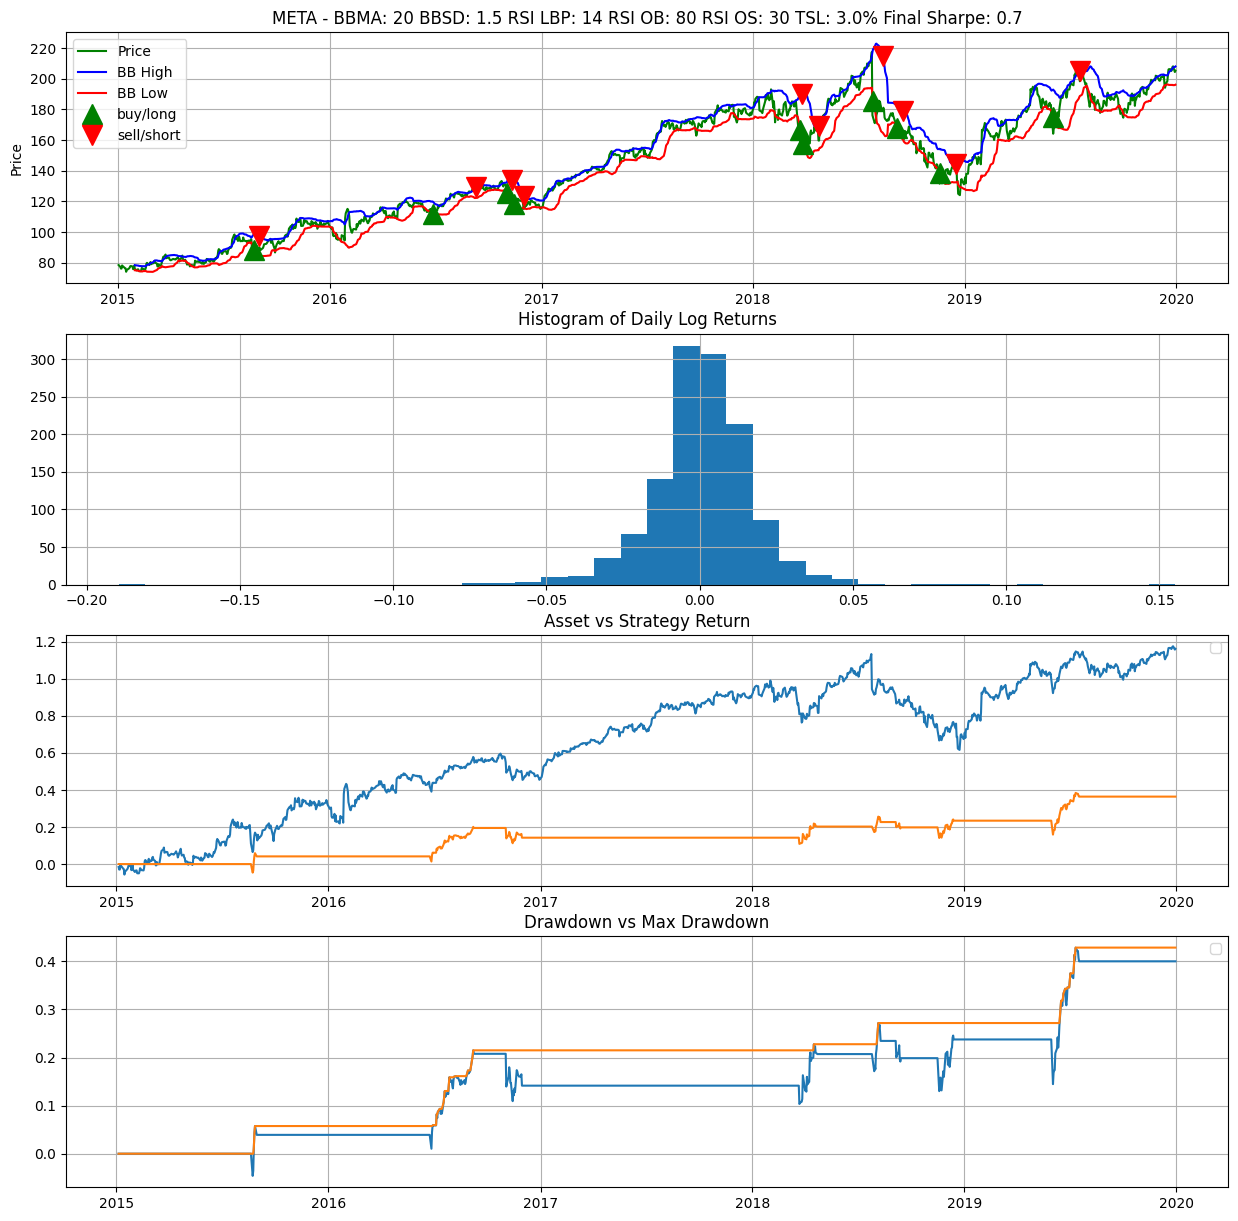

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


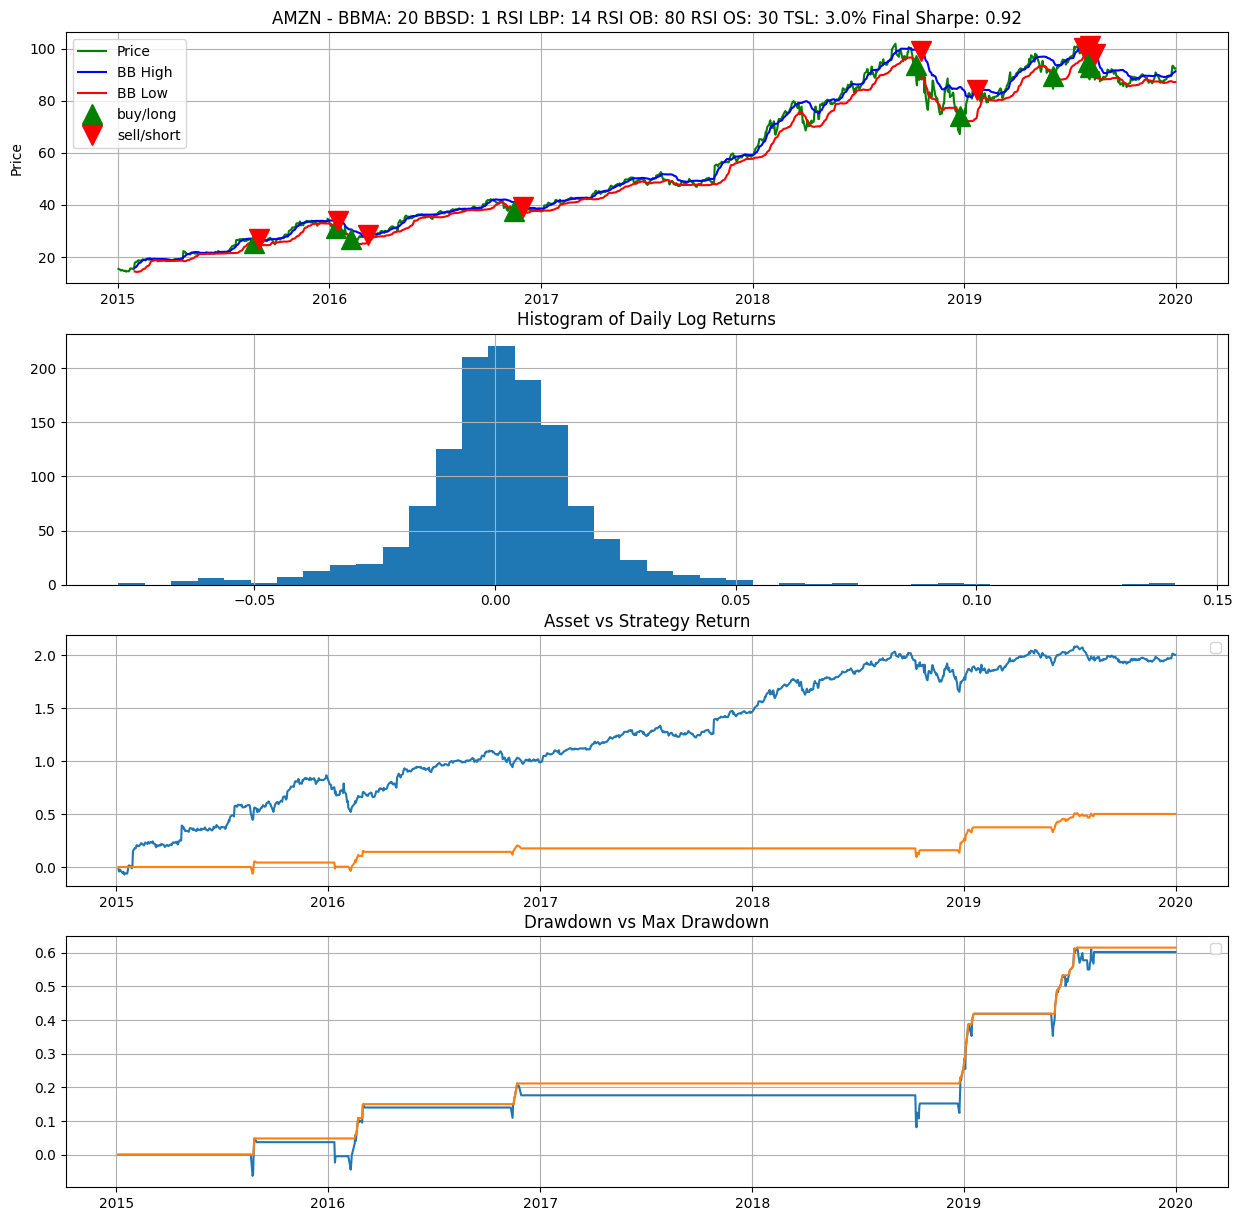

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


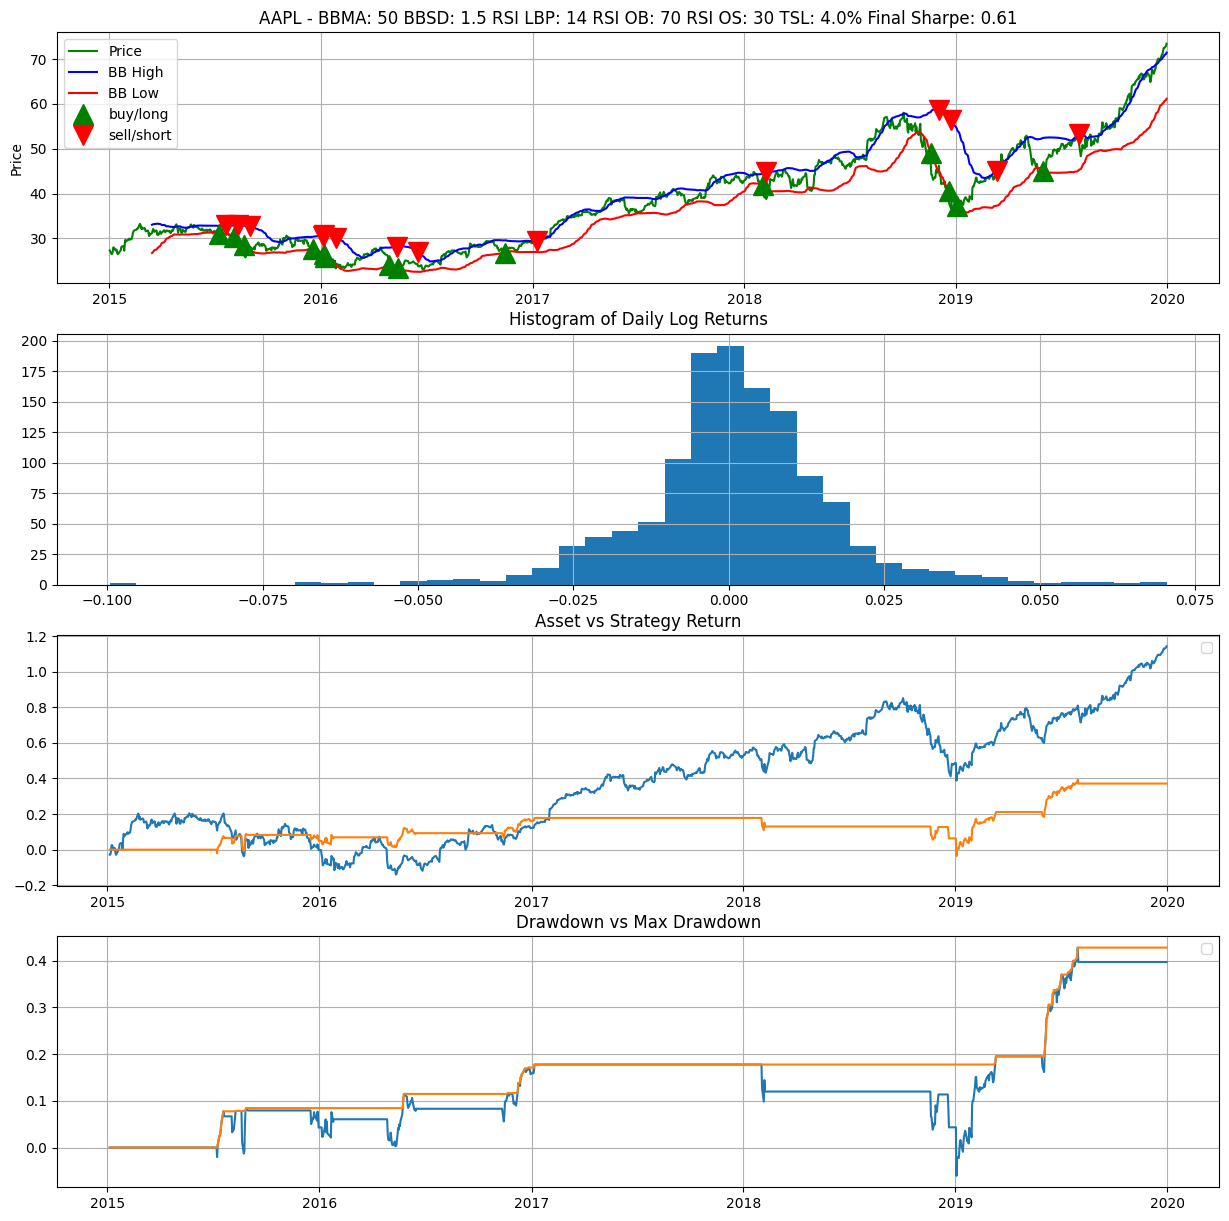

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


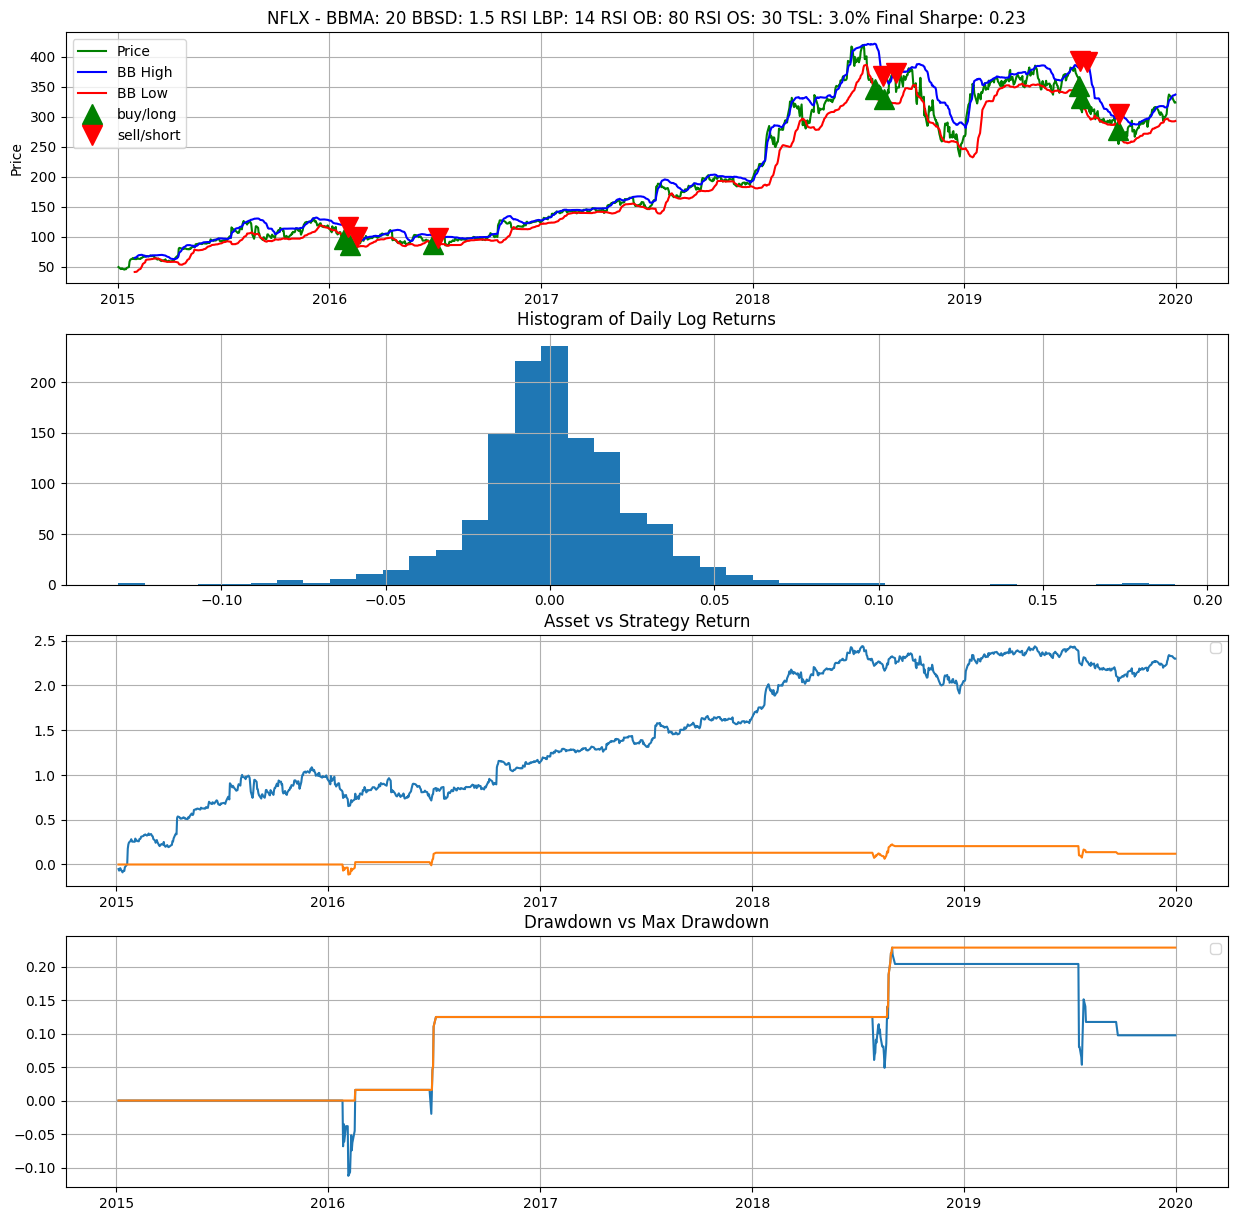

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


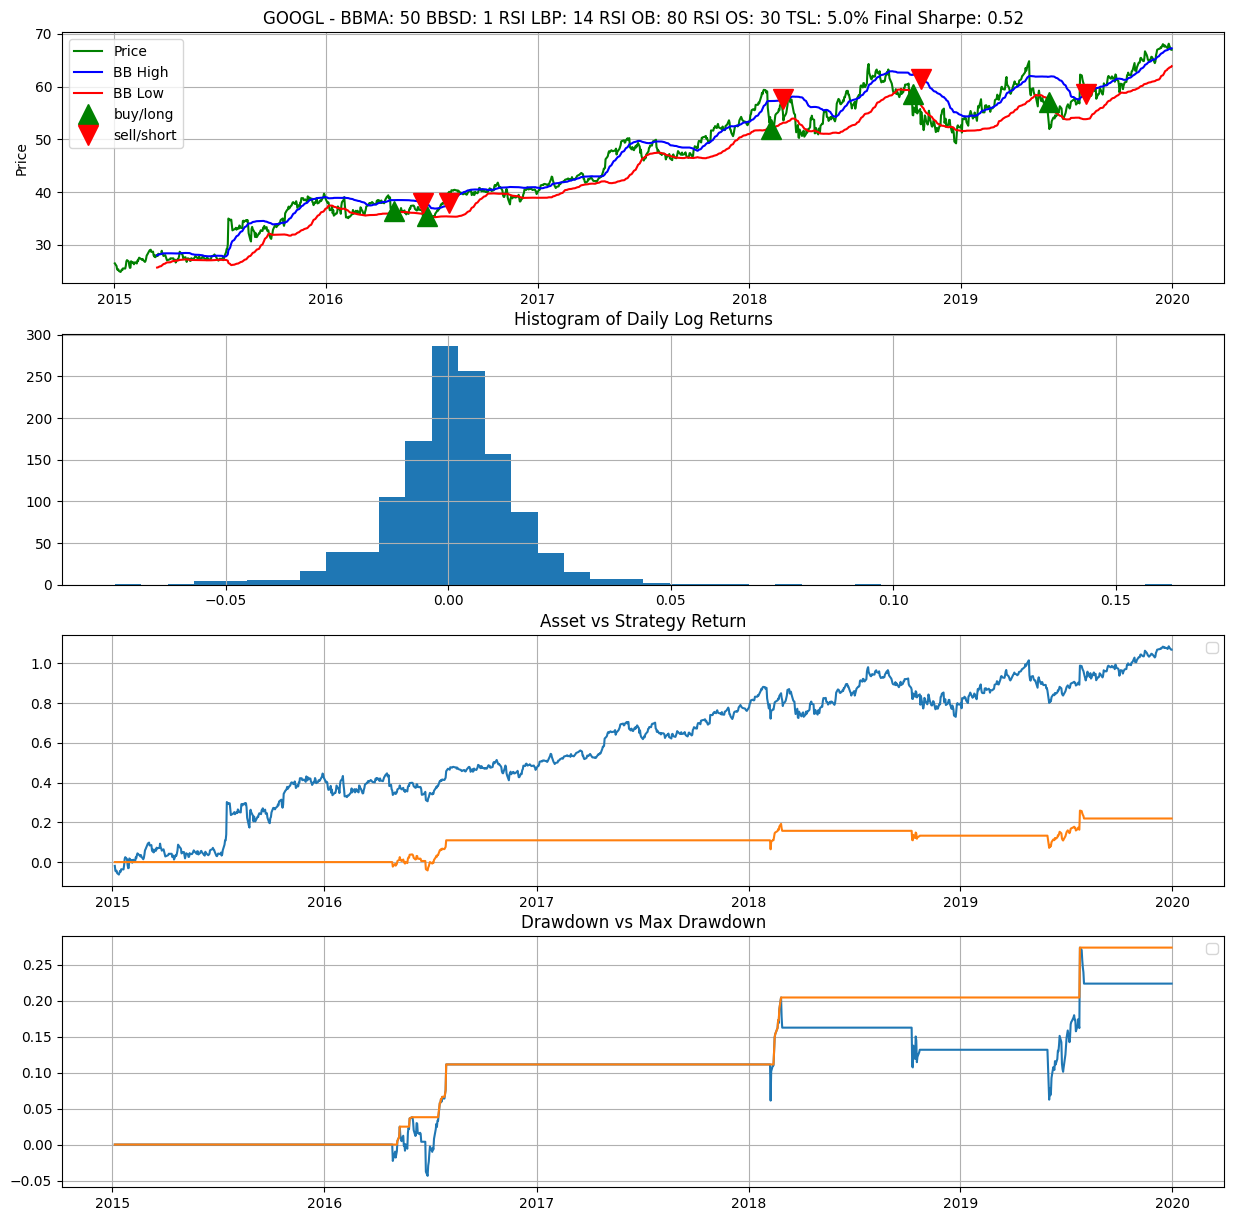

,Annualized Regular Returns,Annualized Regular Std Dev,Annualized Log Std Dev,Annualized Log Returns,Beta,Alpha,Tremor Ratio,Sharpe Ratio,Sortino Ratio,Max Drawdown,Calmar Ratio,Max Drawdown Duration,Information Ratio,Final Cumulative Return
META,0.073009,0.104854,0.105160,0.067487,0.184678,0.054694,0.395333,0.696294,0.322857,0.141641,0.515454,587 days,-0.174413,0.400220
AMZN,0.100377,0.108640,0.107730,0.094529,0.301523,0.070474,0.332900,0.923944,0.395230,0.130151,0.771232,764 days,0.008723,0.602430
AAPL,0.074462,0.121570,0.122032,0.067034,0.341829,0.040562,0.217835,0.612504,0.330932,0.238336,0.312426,403 days,-0.172367,0.397061
NFLX,0.024072,0.103516,0.104827,0.018630,0.068791,0.017250,0.349931,0.232546,0.057317,0.174833,0.137687,26 days,-0.461739,0.097382
GOOGL,0.043938,0.084052,0.083531,0.040435,0.146459,0.029413,0.300000,0.522742,0.220775,0.141896,0.309647,515 days,-0.390879,0.223473


In [418]:
results_df = pd.DataFrame(columns=list(results['META'][1].keys()))
for symbol in results:
    results_df.loc[symbol] = results[symbol][1]
    signals_returns(symbol)

results_df

In [419]:
portfolio_weights = {
    'META': 0.2051,
    'AMZN': 0.6294,
    'GOOGL': 0.1655
}

df = pd.DataFrame(index=results[next(iter(results))][0].index, 
                         columns=['Combined Strategy Returns'])
df['Benchmark'] = yf.download('SPY', start="2015-01-01", end="2020-01-01")['Close']
df['Combined Strategy Return'] = 0
for symbol in portfolio_weights:
  df['Combined Strategy Return'] += portfolio_weights[symbol]*results[symbol][0]['Strategy Regular Return']

df['Benchmark Log Return'] = np.log(df['Benchmark']/df['Benchmark'].shift(1))
df['Benchmark Regular Return'] = df['Benchmark'].pct_change()

df['Cumulative Market Returns'] = np.exp(df['Benchmark Log Return'].cumsum()) -1
df['Cumulative Combined Strategy Returns'] = np.exp(df['Combined Strategy Return'].cumsum()) -1

  # Annualized Return
annualized_regular_return = df['Combined Strategy Return'].mean() * 252
annualized_regular_std = df['Combined Strategy Return'].std() * np.sqrt(252)

# Calculate Beta
cov_matrix = np.cov(df['Combined Strategy Return'][1:], df['Benchmark Regular Return'][1:])
beta = cov_matrix[0, 1] / cov_matrix[1, 1]

# Calculate Alpha (assuming risk-free rate = 0)
market_return = df['Benchmark Regular Return'].mean() * 252
strategy_return = df['Combined Strategy Return'].mean() * 252
alpha = strategy_return - (beta * market_return)

# Sharpe Ratio (assuming risk-free rate = 0)
sharpe_ratio = annualized_regular_return / annualized_regular_std

# Sortino Ratio
df['Negative Return'] = df[df['Combined Strategy Return']<0]['Combined Strategy Return']
negative_regular_return = np.exp(df['Negative Return']) -1
annualized_negative_sd = negative_regular_return.std() * np.sqrt(252)
sortino_ratio = annualized_regular_return / annualized_negative_sd

# Maximum Drawdown
df['Running Max'] = df['Cumulative Combined Strategy Returns'].cummax()
df['Drawdown'] = df['Running Max'] - df['Cumulative Combined Strategy Returns']
max_drawdown = df['Drawdown'].max()
zero_periods = df['Drawdown'][df['Drawdown'] == 0]
delta_values = zero_periods.index[1:] - zero_periods.index[:-1]
max_drawdown_duration = delta_values.max()

# Treymor
treymor_ratio = annualized_regular_return / beta

# Calmar ratio
calmar_ratio = annualized_regular_return / max_drawdown

# Information ratio
average_of_difference = (df['Combined Strategy Return'] - df['Benchmark Regular Return']).mean()
std_of_difference = (df['Combined Strategy Return'] - df['Benchmark Regular Return']).std()
information_ratio_daily = average_of_difference / std_of_difference
information_ratio = information_ratio_daily * np.sqrt(252)


metrics = {
    'Annualized Regular Returns': annualized_regular_return,
    'Annualized Regular Std Dev': annualized_regular_std,
    'Beta': beta,
    'Alpha': alpha,
    'Tremor Ratio': treymor_ratio,
    'Sharpe Ratio': sharpe_ratio,
    'Sortino Ratio': sortino_ratio,
    'Max Drawdown': max_drawdown,
    'Calmar Ratio': calmar_ratio,
    'Max Drawdown Duration': max_drawdown_duration,
    'Information Ratio': information_ratio,
    'Final Cumulative Return': df['Cumulative Combined Strategy Returns'].iloc[-1]
}

for m in metrics:
  print(m, metrics[m])

[*********************100%%**********************]  1 of 1 completed
Annualized Regular Returns 0.08542307138434035
Annualized Regular Std Dev 0.08244869234728379
Beta 0.25189471627557614
Alpha 0.06044192097257868
Tremor Ratio 0.3391221247010453
Sharpe Ratio 1.0360755149945633
Sortino Ratio 0.5960453740470709
Max Drawdown 0.08324704232059599
Calmar Ratio 1.0261394159250028
Max Drawdown Duration 511 days 00:00:00
Information Ratio -0.10920433172866068
Final Cumulative Return 0.5312714687115949
